In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os, sys
os.chdir('/content/drive/MyDrive/1cylinder')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# import meshio
import numpy as np
from scipy import stats
import os, sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import time

from copy import deepcopy as cp
from sklearn.linear_model import Lasso
from scipy.integrate import solve_ivp
from math import sqrt
from joblib import Parallel, delayed

from copy import deepcopy as cp
import numpy as np
from sklearn.decomposition import PCA

import pandas as pd
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Add, Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm
import os, sys
import urllib.request



from scipy import stats
from process import *

In [ ]:
sys.path.append('/content/drive/MyDrive/1cylinder/scr/')
from utils_plot import *  # contour
from utils_sindy import *
from loops import *
from process import *
from autoencoder import *

# one cylinder





## 3 ROM-SAE+POD-SINDy


### 3.4 sae-sindy

#### sae_data

In [ ]:
X0_sae = X0_sae.reshape((len(X0_sae),128*64))

In [ ]:
model_name = './sae_u_2000_relu_version.hdf5'
input_dim = 128*64
layer_dim = [64*16,16*8,10*4,15,2]
latent_dim = 2
active = 'relu'

In [ ]:
os.chdir('/content/drive/MyDrive/1cylinder/Model/')
autoencoder_sae, encoder_sae, decoder_sae = load_autoencoder(model_name, input_dim, latent_dim)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8192)]            0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 40)                5160      
                                                                 
 dense_3 (Dense)             (None, 15)                615       
                                                                 
 dense_4 (Dense)             (None, 2)                 32        
                                                                 
 dense_5 (Dense)             (None, 15)                45    

In [ ]:
r = np.load('./data_sae_pod.npy')

In [ ]:
# Xor = cp(Xor2)
Xor = cp(r)
r_min11 = np.min(Xor,axis=0)
r_max11 = np.max(Xor,axis=0)
for i in range(len(Xor)):
  Xor[i,:] = (2*Xor[i,:]-r_max11-r_min11)/(r_max11-r_min11)

# 判断是否有Nan
for i in range(len(Xor)):
  for j in range(2):
    if np.isnan(Xor[i,j]):
      print(i,j)

# np.save(os.path.join(store_path,'Xor.npy'),Xor)
# Xor = np.load(os.path.join(store_path,'Xor.npy'))

In [ ]:
print(Xor.shape)
sae_pca = PCA(n_components=2)
Xor2 = sae_pca.fit_transform(Xor)
print(Xor2.shape)
# print(pca1.explained_variance_ratio_)
re_Xor = sae_pca.inverse_transform(Xor2)
print(1-np.linalg.norm(re_Xor-Xor)/np.linalg.norm(Xor))

(2000, 2)
(2000, 2)
0.9999998720094254


In [ ]:
Xor = cp(Xor2)
# Xor = cp(r)
r_min12 = np.min(Xor,axis=0)
r_max12 = np.max(Xor,axis=0)
for i in range(len(Xor)):
  Xor[i,:] = (2*Xor[i,:]-r_max12-r_min12)/(r_max12-r_min12)

# 判断是否有Nan
for i in range(len(Xor)):
  for j in range(2):
    if np.isnan(Xor[i,j]):
      print(i,j)

# np.save(os.path.join(store_path,'Xor.npy'),Xor)
# Xor = np.load(os.path.join(store_path,'Xor.npy'))

In [ ]:
dt = 0.05

# r1 = cp(Xor2[:,0])
# r2 = cp(Xor2[:,1])
r1 = cp(Xor[:,0])
r2 = cp(Xor[:,1])

data = np.zeros([len(r1)-2,2])
data[:,0] = r1[1:len(r1)-1]
data[:,1] = r2[1:len(r2)-1]
print(data.shape)

ddata=np.empty_like(data)
for i in range(len(r1)-2):
    ddata[i,0]=(r1[i+2]-r1[i])/(2*dt)
    ddata[i,1]=(r2[i+2]-r2[i])/(2*dt)
# 2nd-order
print(ddata.shape)

(1998, 2)
(1998, 2)


In [ ]:
# n_ts = 3000
dtsnap = 0.05
taxx=np.arange(0,dtsnap*n_ts,dtsnap)
tax=np.arange(dtsnap,dtsnap*(n_ts-1)-1e-5,dtsnap)  # 1000
# tax=np.arange(dtsnap,dtsnap*(n_ts-2)+1e-5,dtsnap)
# tax=np.arange(dtsnap,dtsnap*(n_ts-1),dtsnap)
print(tax.shape)
print(taxx.shape)
print(data.shape)

(1998,)
(2000,)
(1998, 2)


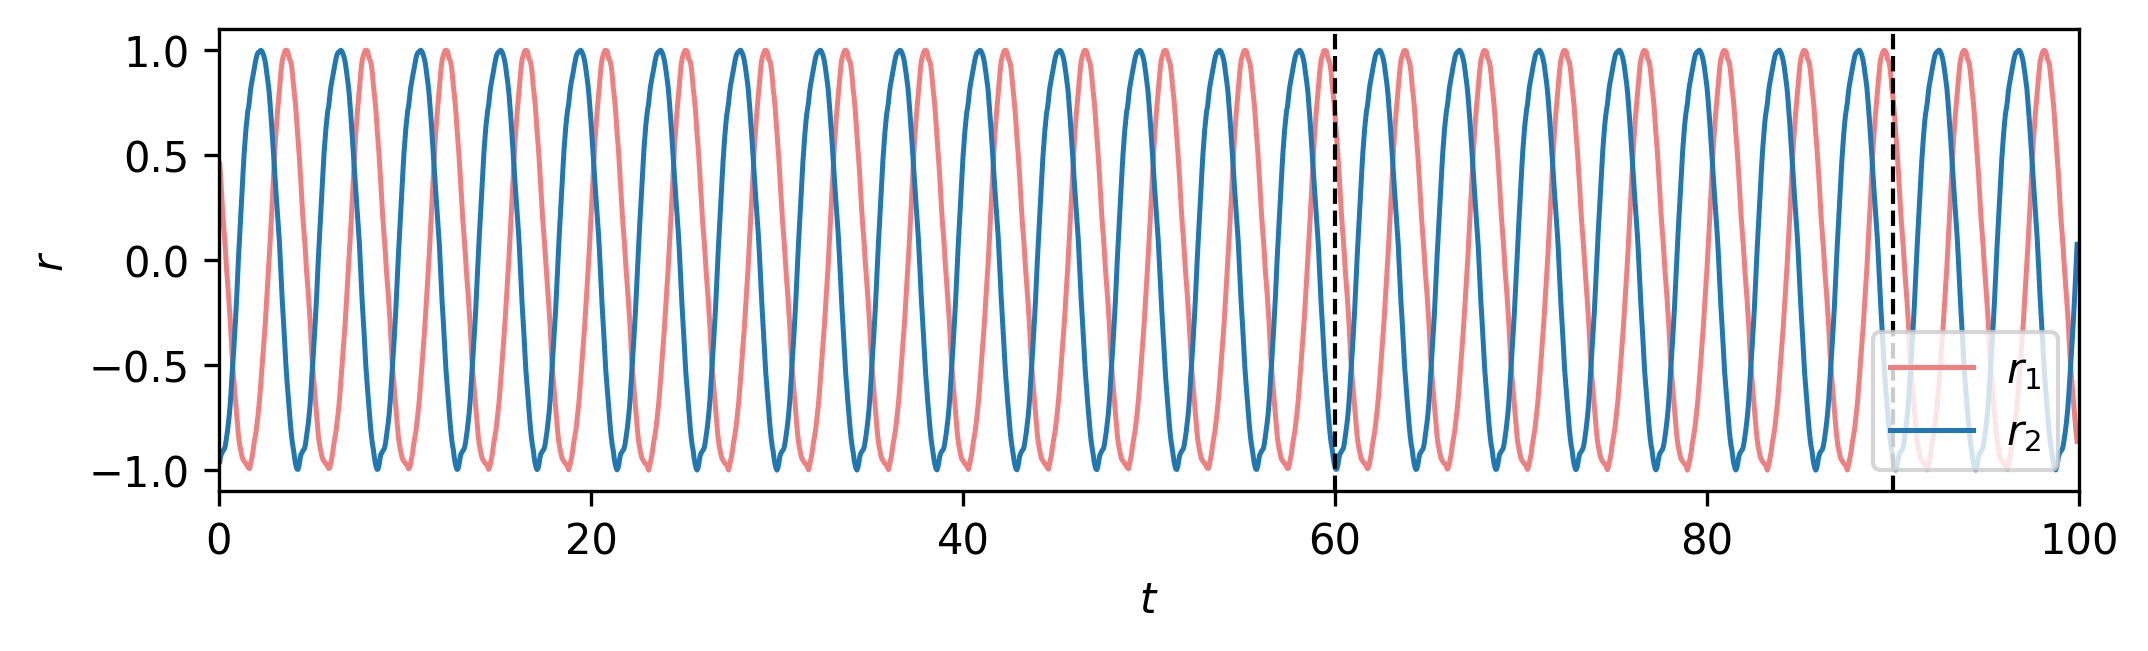

In [ ]:
fig=plt.figure(dpi=300,figsize=(8,2))
plt.plot(tax,data[:,0],label=r'$r_1$',lw=1.2,color='lightcoral')
plt.plot(tax,data[:,1],label=r'$r_2$',lw=1.2)
plt.xlim([0,100])
plt.legend(loc='lower right')#,fontsize=12)
plt.xlabel(r'$t$')#,fontsize=20)
plt.ylabel(r'$r$')#,fontsize=20)
# plt.title('1 cylinder latent vector by SAE+POD')
plt.axvline(x=60,c="k",ls="--",lw=1)
plt.axvline(x=90,c="k",ls="--",lw=1)
plt.show()

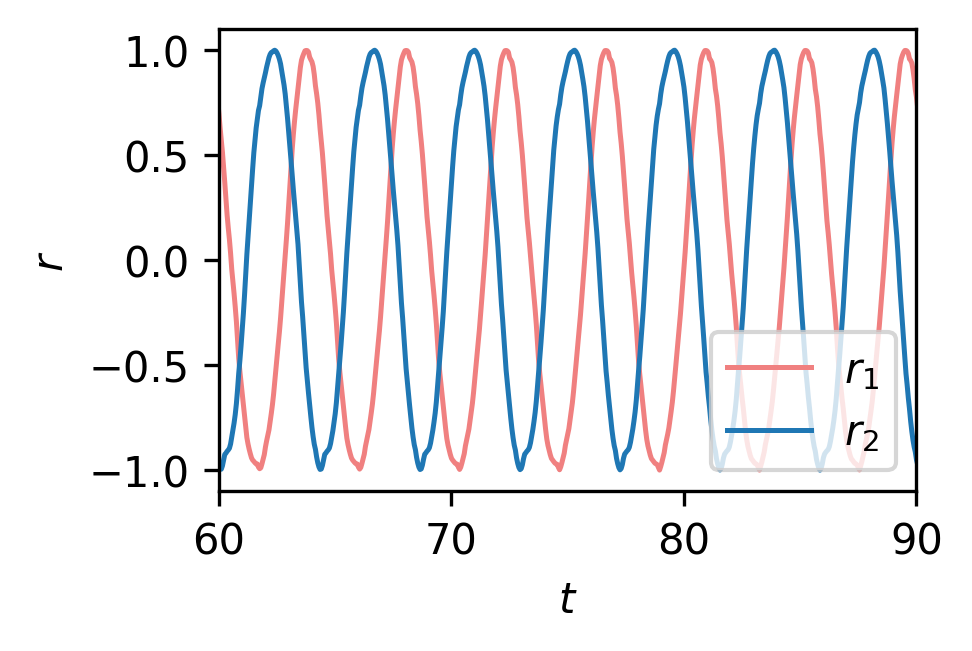

In [ ]:
# os.chdir(('/content/drive/MyDrive/1cylinder/retry'))
# model_name='./sae_u_2000_relu_2.hdf5'
fig=plt.figure(dpi=300,figsize=(3,2))
plt.plot(tax,data[:,0],label=r'$r_1$',lw=1.2,color='lightcoral')
plt.plot(tax,data[:,1],label=r'$r_2$',lw=1.2)
plt.xlim([60,90])
plt.legend(loc='lower right')#,fontsize=12)
plt.xlabel(r'$t$')#,fontsize=20)
plt.ylabel(r'$r$')#,fontsize=20)
# plt.title('1 cylinder latent vector by SAE+POD')
plt.show()

In [ ]:
# data_sae = data
np.save('./data_sae.npy',data_sae)
data_sae = np.load('./data_sae.npy')

In [ ]:
# data_sae_pod = data
np.save('./data_sae_pod.npy',data_sae_pod)
data_sae_pod = np.load('./data_sae_pod.npy')

##### fre

st = fL/V



In [ ]:
from process import *

In [ ]:
fre = strouhal(data.T,dt)
print(fre)
print(data.shape)

0.23034551827741614
(1998, 2)


In [ ]:
Xor2 = cp(r)

In [ ]:
# alaaso
n_order = 3   # 5
usesin = False
usesint = True
uset = True
# usfl = 0
n=0  # 第n个alr


stat = 0.05 # tax.shape[0] = n_ts-2
endt = 0.05*(n_ts-2)
taxint = np.arange(stat,endt+1e-5,dt)

In [ ]:
alr = np.array([\
                # 2e-9,3e-9,4e-9,5e-9,6e-9,7e-9,8e-9,9e-9,\
                # 1e-8,2e-8,3e-8,4e-8,5e-8,6e-8,7e-8,8e-8,9e-8,\
                # 1e-7,2e-7,3e-7,4e-7,5e-7,6e-7,7e-7,8e-7,9e-7,\
                # 1e-6,2e-6,3e-6,4e-6,5e-6,6e-6,7e-6,8e-6,9e-6,\
                # 1e-5,2e-5,3e-5,4e-5,5e-5,6e-5,7e-5,8e-5,9e-5,\
                1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,\
                1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3,8e-3,\
                # 1e-2,2e-2,3e-2,4e-2,5e-2,6e-2,7e-2,8e-2,9e-2,\
                # 1e-1,2e-1,3e-1,4e-1,5e-1,6e-1,7e-1,8e-1,9e-1,\
                ])


rms11 = np.zeros_like(alr)
mean11 = np.zeros_like(alr)
nxcmp1 = np.zeros_like(alr)
nycmp1 = np.zeros_like(alr)
aic11 = np.zeros_like(alr)
starray = np.zeros_like(alr)
sig = np.ones_like(alr)
L2_error = np.ones_like(alr)


PCC_list_sae = np.ones((len(alr),2))
RMSE_list_sae = np.ones_like(alr)
PCC_list_sae_pod = np.ones((len(alr),2))
RMSE_list_sae_pod = np.ones_like(alr)

In [ ]:
regression = 'alasso'
alpha, xi, vodet, vodey, draw = cal_sindy_k(n,data,ddata,alr)
print(xi)
num_r1=np.count_nonzero(xi[:,0])
num_r2=np.count_nonzero(xi[:,1])
aic = AIC(data,vodey,vodet,xi)
mean1,rms1 = rms_and_mean(vodey,vodet)
alpha, xi, vodet, vodey, num_r1, num_r2, draw, aic, mean1, rms1=loop2(n,data,ddata,alr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e+01, tolerance: 2.227e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.531e+01, tolerance: 2.316e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.638e+01, tolerance: 2.316e

count_nonzero(xi):  7
[[-0.    -0.   ]
 [ 1.765 -1.947]
 [-0.    -0.   ]
 [-0.     1.566]
 [ 1.053 -2.041]
 [ 0.     0.   ]
 [ 0.     2.168]
 [-0.    -0.   ]
 [-0.     1.283]
 [-0.     0.   ]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [-0.     0.   ]
 [-0.     0.   ]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e+01, tolerance: 2.227e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.531e+01, tolerance: 2.316e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.638e+01, tolerance: 2.316e

count_nonzero(xi):  7


ValueError: ignored

In [ ]:
alpha, xi, vodet, vodey, num_r1, num_r2, draw, aic, mean1,rms1=loop2(n,data,ddata,alr)
alpha, xi, vodet, vodey, draw = cal_sindy_k(n,data,ddata,alr,regression)

count_nonzero(xi):  13
0.3682282282416887 -0.25660791921678494
[64.64503904 70.88321879]
[-0.26352035  0.00691243]
count_nonzero(xi):  13


In [ ]:
fre = strouhal(data.T,dt)

In [ ]:
data = data_sae_pod
ddata = ddata_sae_pod


delta = 2
# n_ts=2000，u
n_order=3

usesin = False
uset = True
usesint = True

regression = 'alasso'

import warnings
warnings.filterwarnings("ignore") # 忽略不收敛警告

# def AIC(data,vodey,vodet):
# def rms_and_mean(vodey,vodet):   return mean1,rms1

print('mean,rms',rms_and_mean(data.T,taxint))


for n in range(len(alr)):
  alpha, xi, vodet, vodey, num_r1, num_r2, draw, aic, mean1,rms1,L2_error1,fre1=loop2(n,data,ddata,alr)
  if ~np.isnan(draw):
    p1 = stats.pearsonr(vodey[0,:].T, data[:,0])[0]
    p2 = stats.pearsonr(vodey[1,:].T, data[:,1])[0]
    print('PCC',p1,p2)
    RMSE = np.sqrt(((vodey.T-data) ** 2).mean())
    print('RMSE',RMSE)
    PCC_list_sae_pod[n,0] = p1
    PCC_list_sae_pod[n,1] = p2
    RMSE_list_sae_pod[n] = RMSE
  print("n",n,"alpha",alpha)
  # print(draw)
  print('n_r1:',num_r1, ' n_r2:', num_r2)
  print('aic',aic)
  print('mean1,rms1',mean1,rms1)
  print('L2_error1',L2_error1)
  print('fre1',fre1)
  rms11[n] = rms1
  mean11[n] = mean1
  nxcmp1[n] = num_r1+num_r2
  aic11[n] = aic
  L2_error[n] = L2_error1
  starray[n] = fre1

  if ~np.isnan(num_r1):

    # Original and reproduced time history

    # fig=plt.figure(dpi=300,figsize=(8,2))
    fig=plt.figure(dpi=300,figsize=(6,2))

    plt.axes([0.1,0.5,0.8,0.5])
    plt.plot(taxint,data[:,0],lw=1,label=r'$r_1$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$')
    plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)

    plt.axes([0.1,0.0,0.8,0.5])  #, ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,1],lw=1,label=r'$r_2$',color='darkgray')
    plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$')
    plt.legend(loc='lower right')
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)

    fig=plt.figure(dpi=300,figsize=(6,2))

    plt.axes([0.1,0.5,0.8,0.5])
    plt.plot(taxint,data[:,0],lw=1,label=r'$r_1$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$')
    plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)
    plt.xlim([20,50])

    plt.axes([0.1,0.0,0.8,0.5])  #, ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,1],lw=1,label=r'$r_2$',color='darkgray')
    plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$')
    plt.legend(loc='lower right')
    plt.xlim([20,50])

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(PCC_list_sae_pod)
print(RMSE_list_sae_pod)

[[0.2398964  0.25850764]
 [0.98423829 0.98508416]
 [0.99576656 0.9970954 ]
 [0.99616018 0.99770933]
 [0.99337344 0.99460322]
 [0.99118624 0.99248715]
 [0.99437489 0.99583363]
 [0.97889285 0.9815272 ]
 [0.98801008 0.99025262]
 [0.95507368 0.95628226]
 [0.95653156 0.95741092]
 [0.93494879 0.93572904]
 [0.92416287 0.92467948]
 [0.90392354 0.90426942]
 [0.88354223 0.88347996]
 [0.85827942 0.8579377 ]
 [0.85211174 0.85106674]]
[0.69473575 0.12600821 0.07642085 0.07265415 0.09157006 0.10294097
 0.08486639 0.14874817 0.11472163 0.21606628 0.21302094 0.25852249
 0.27718152 0.31059074 0.34109644 0.37531676 0.38361328]


In [ ]:
data = data_sae
ddata = ddata_sae


delta = 3
# n_ts=2000，u
n_order=3

usesin = False
uset = True
usesint = True

regression = 'alasso'

import warnings
warnings.filterwarnings("ignore") # 忽略不收敛警告

# def AIC(data,vodey,vodet):
# def rms_and_mean(vodey,vodet):   return mean1,rms1

print('mean,rms',rms_and_mean(data.T,taxint))


for n in range(len(alr)):
  alpha, xi, vodet, vodey, num_r1, num_r2, draw, aic, mean1,rms1,L2_error1,fre1=loop2(n,data,ddata,alr)
  if type(vodey)!=float:
    if vodey.shape[1]==data.shape[0]:
      p1 = stats.pearsonr(vodey[0,:].T, data[:,0])[0]
      p2 = stats.pearsonr(vodey[1,:].T, data[:,1])[0]
      print('PCC',p1,p2)
      RMSE = np.sqrt(((vodey.T-data) ** 2).mean())
      print('RMSE',RMSE)
      PCC_list_sae[n,0] = p1
      PCC_list_sae[n,1] = p2
      RMSE_list_sae[n] = RMSE
  print("n",n,"alpha",alpha)
  # print(draw)
  print('n_r1:',num_r1, ' n_r2:', num_r2)
  print('aic',aic)
  print('mean1,rms1',mean1,rms1)
  print('L2_error1',L2_error1)
  print('fre1',fre1)
  rms11[n] = rms1
  mean11[n] = mean1
  nxcmp1[n] = num_r1+num_r2
  aic11[n] = aic
  L2_error[n] = L2_error1
  starray[n] = fre1

  if ~np.isnan(num_r1):

    # Original and reproduced time history

    # fig=plt.figure(dpi=300,figsize=(8,2))
    fig=plt.figure(dpi=300,figsize=(6,2))

    plt.axes([0.1,0.5,0.8,0.5])
    plt.plot(taxint,data[:,0],lw=1,label=r'$r_1$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$')
    plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)

    plt.axes([0.1,0.0,0.8,0.5])  #, ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,1],lw=1,label=r'$r_2$',color='darkgray')
    plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$')
    plt.legend(loc='lower right')
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)

    fig=plt.figure(dpi=300,figsize=(6,2))

    plt.axes([0.1,0.5,0.8,0.5])
    plt.plot(taxint,data[:,0],lw=1,label=r'$r_1$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$')
    plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)
    plt.xlim([60,90])

    plt.axes([0.1,0.0,0.8,0.5])  #, ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,1],lw=1,label=r'$r_2$',color='darkgray')
    plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$')
    plt.legend(loc='lower right')
    plt.xlim([60,90])

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(PCC_list_sae)
print(RMSE_list_sae)

[[0.18029062 0.18332466]
 [0.08721348 0.08671263]
 [0.8771111  0.87822669]
 [0.8771111  0.87822669]
 [0.8771111  0.87822669]
 [0.8771111  0.87822669]
 [0.8771111  0.87822669]
 [0.8771111  0.87822669]
 [0.8771111  0.87822669]
 [0.86453123 0.86552132]
 [0.85048779 0.85136748]
 [0.82152196 0.82226221]
 [0.8057015  0.80640862]
 [0.79037893 0.79107983]
 [0.75723833 0.7579969 ]
 [0.73940397 0.74022696]
 [0.72229271 0.72319658]]
[0.90806886 0.98513569 0.36378757 0.36378757 0.36378757 0.36378757
 0.36378757 0.36378757 0.36378757 0.38148419 0.40030277 0.43649929
 0.45503206 0.47226575 0.50750998 0.52548517 0.54215306]


### loop results

In [ ]:
print(PCC_list_sae)
print(PCC_list_sae_pod)

In [ ]:
print(alr)

[0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001
 0.002  0.003  0.004  0.005  0.006  0.007  0.008 ]


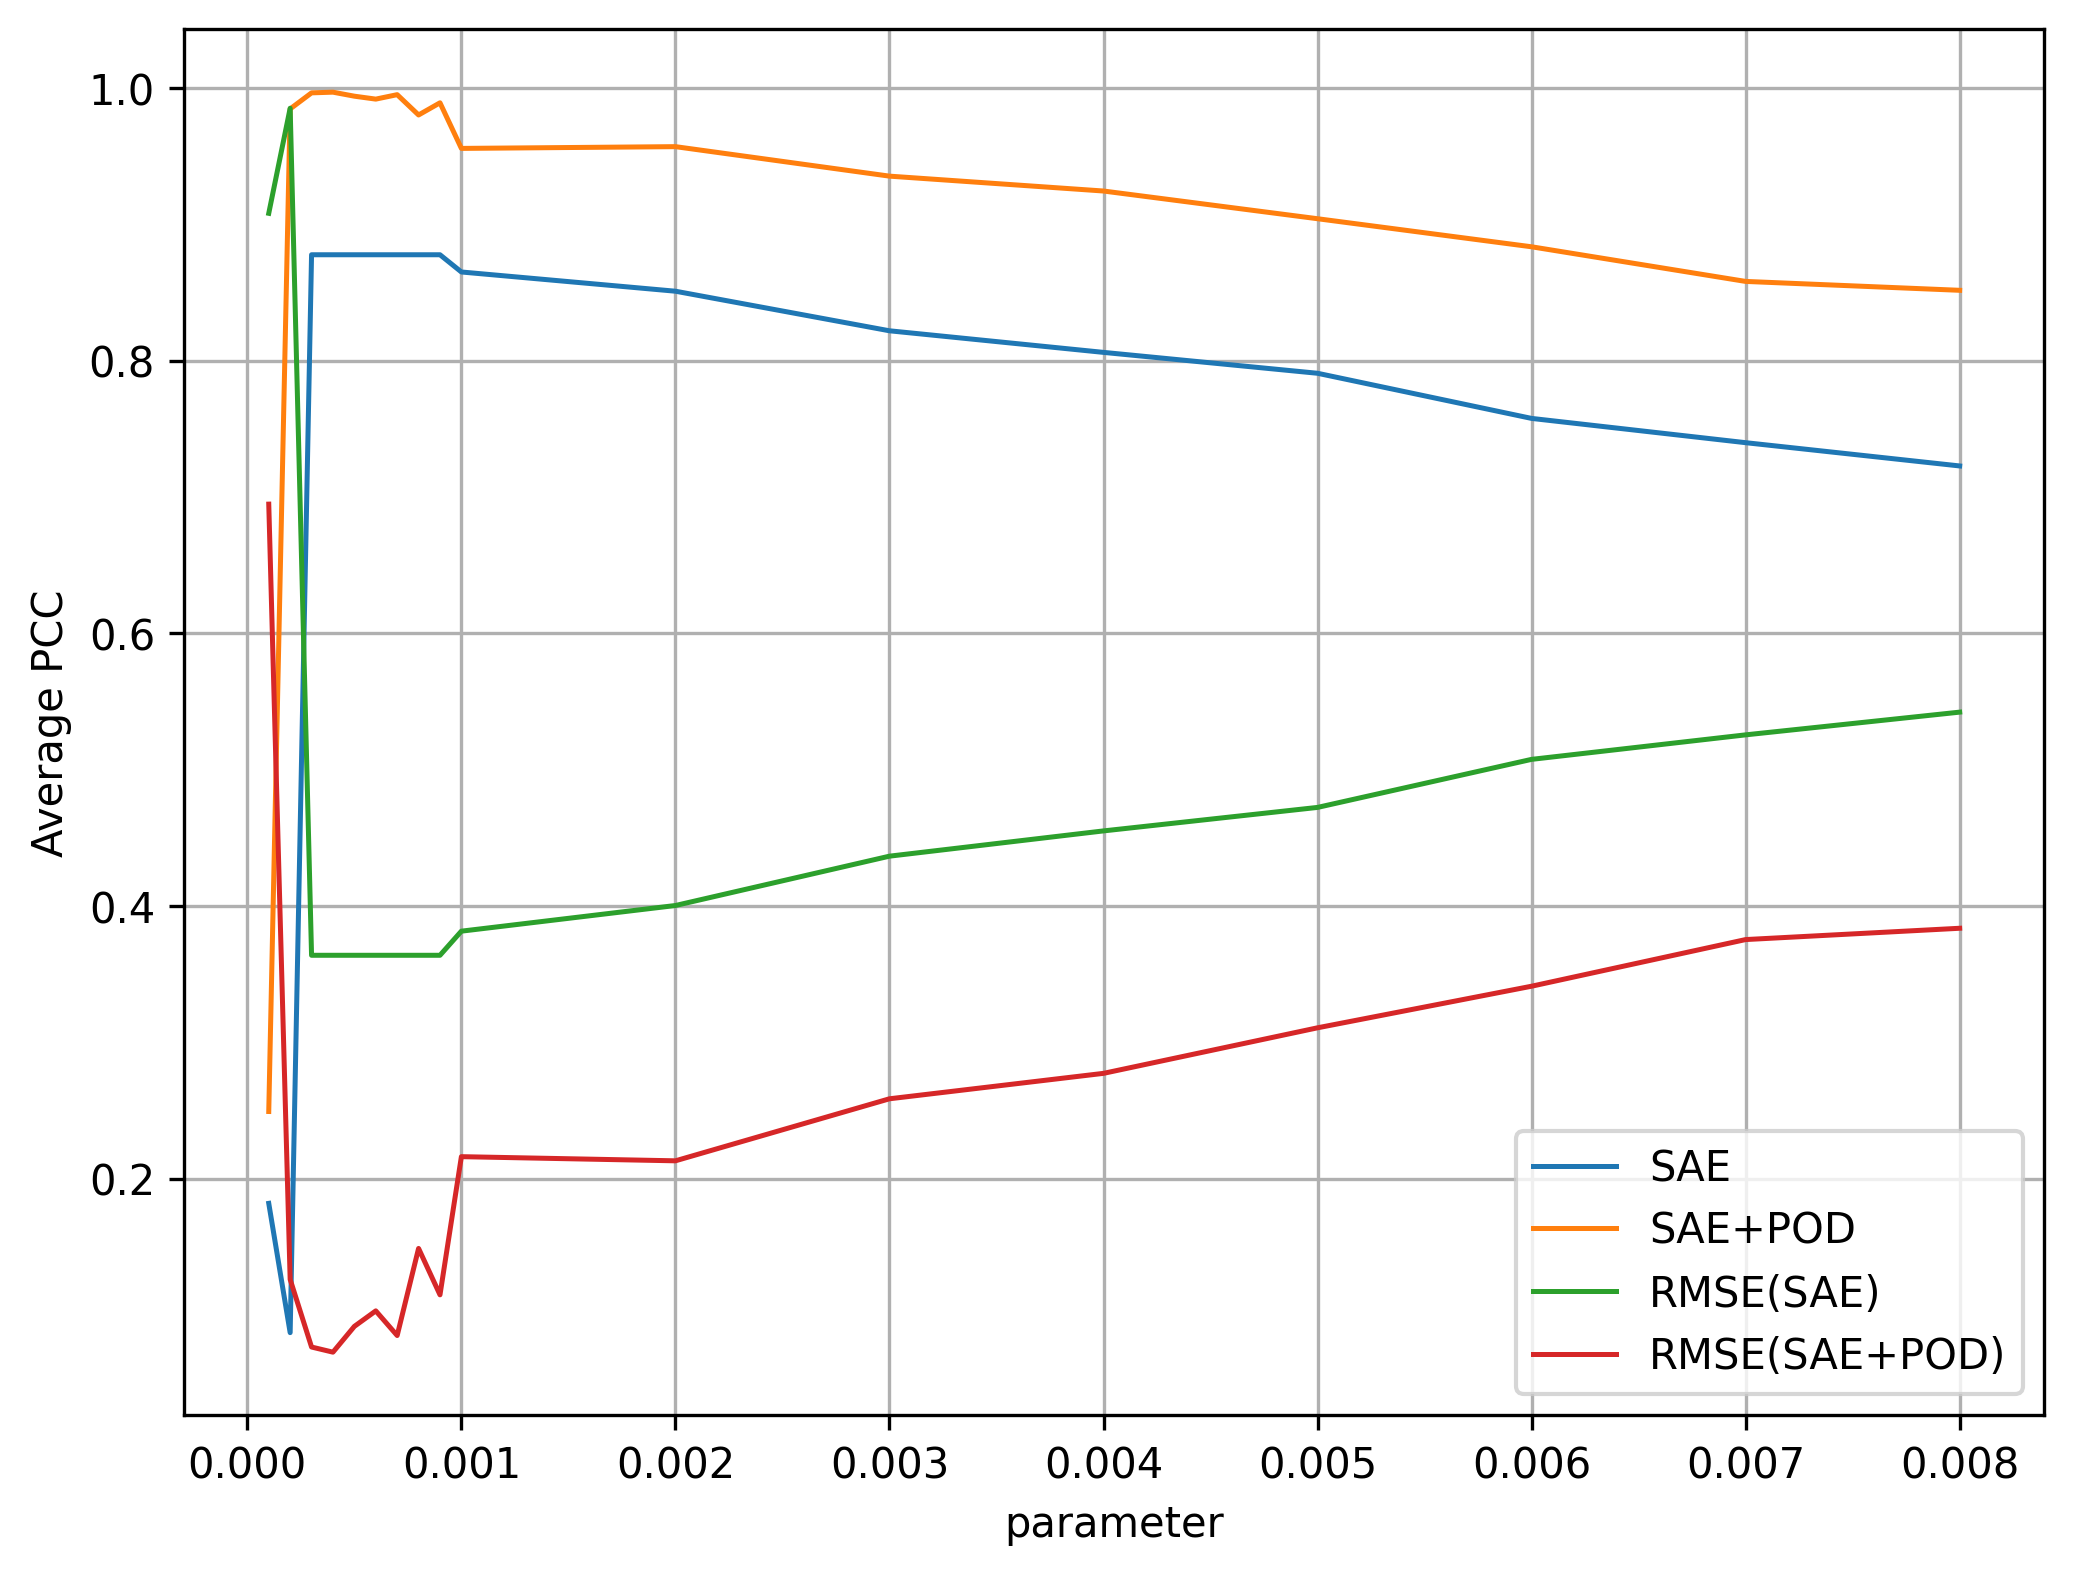

In [ ]:
plt.figure(dpi=300,figsize=(8,6))
plt.plot(alr, (PCC_list_sae[:,0]+PCC_list_sae[:,1])/2,'-',lw=1.2,label='SAE')
plt.plot(alr, (PCC_list_sae_pod[:,0]+PCC_list_sae_pod[:,1])/2,'-',lw=1.2,label='SAE+POD')
plt.plot(alr, RMSE_list_sae,'-',lw=1.2,label='RMSE(SAE)')
plt.plot(alr, RMSE_list_sae_pod,'-',lw=1.2,label='RMSE(SAE+POD)')
# plt.plot(alr, PCC_list_sae[:,1],'-',lw=1.2,label='PCC(SAE,r2)')
# plt.plot(alr, PCC_list_sae_pod[:,0],'-',lw=1.2,label='PCC(SAE+POD,r1)')
# plt.plot(alr, PCC_list_sae_pod[:,1],'-',lw=1.2,label='PCC(SAE+POD,r2)')
# plt.plot(alr, RMSE_list_sae,'-',lw=1.2,label='RMSE(SAE)')
# plt.plot(alr, RMSE_list_sae_pod,'-',lw=1.2,label='RMSE(SAE+POD)')
# plt.plot(loss_data2[:,2], loss_data2[:,1],'-',lw=1.2,label='tanh')
# # plt.plot(loss_data3[:,2], loss_data3[:,0],'-',lw=0.5,label=r'loss')
# plt.plot(loss_data3[:,2], loss_data3[:,1],'-',lw=1.2,label='sigmoid')
plt.ylabel('Average PCC')
plt.xlabel('parameter') #,fontsize=8)
# plt.yticks([0,0.02,0.04,0.06,0.08]) #,fontsize=15)
# plt.xlim([-10,210])
# plt.ylim([-0.005,0.08])
# plt.xscale('log')
plt.legend()
plt.grid()
# plt.title('Parameter Choose according to pcc') #,fontsize=8)

### certain alpha  

In [ ]:
print(alr)

[0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001
 0.002  0.003  0.004  0.005  0.006  0.007  0.008 ]


In [ ]:
# Set ALPHA <alr2> to reproduce flow field
# alr2=np.array([1e-3,1.2e-3,2.0e-03])

# n_ts=1000 1.0e-03 1.2e-03 2.0e-03 3.0e-03 1.0e-02 1.2e-02

# the integration time
# stat=tax[0]
# # endt=10000
# taxint=np.arange(dtsnap,endt,dtsnap)

# alr2 = [0.002,7e-07]

alr2 = [0.002,9e-06]

stat = 0.05
endt = 0.05*(n_ts-2)
taxint = np.arange(stat,endt+1e-5,dt)

In [ ]:
alr2 = [0.0007]

In [ ]:
fre = strouhal(data.T,dt)
print(fre)
print(data.shape)

# alaaso
n_order = 3   # 5
usesin = False
usesint = True
uset = True
# usfl = 0
n=0

stat = 0.05 # tax.shape[0] = n_ts-2
endt = 0.05*(n_ts-2)
taxint = np.arange(stat,endt+1e-5,dt)
dtff = cp(dt)

0.23034551827741614
(1998, 2)


In [ ]:
# n_ts = 3000
dtsnap = 0.05
taxx=np.arange(0,dtsnap*n_ts,dtsnap) # 时序数据
tax=np.arange(dtsnap,dtsnap*(n_ts-1)-1e-5,dtsnap)  # 1000

(1998,)
(2000,)
(1998, 2)


mean,rms (-0.11209130923159755, 1.406322241071977)
count_nonzero(xi):  2
PCC 0.877111045111347 0.8782266003708785
fre 0.23034551827741614
n 0 alpha 0.0007
RMSE 0.3637876291098764
aic -2651.7872656568834
mean1,rms1 -0.0012215667154251166 1.481526828004154
n 0 alpha 0.0007
1
n_r1: 1  n_r2: 1


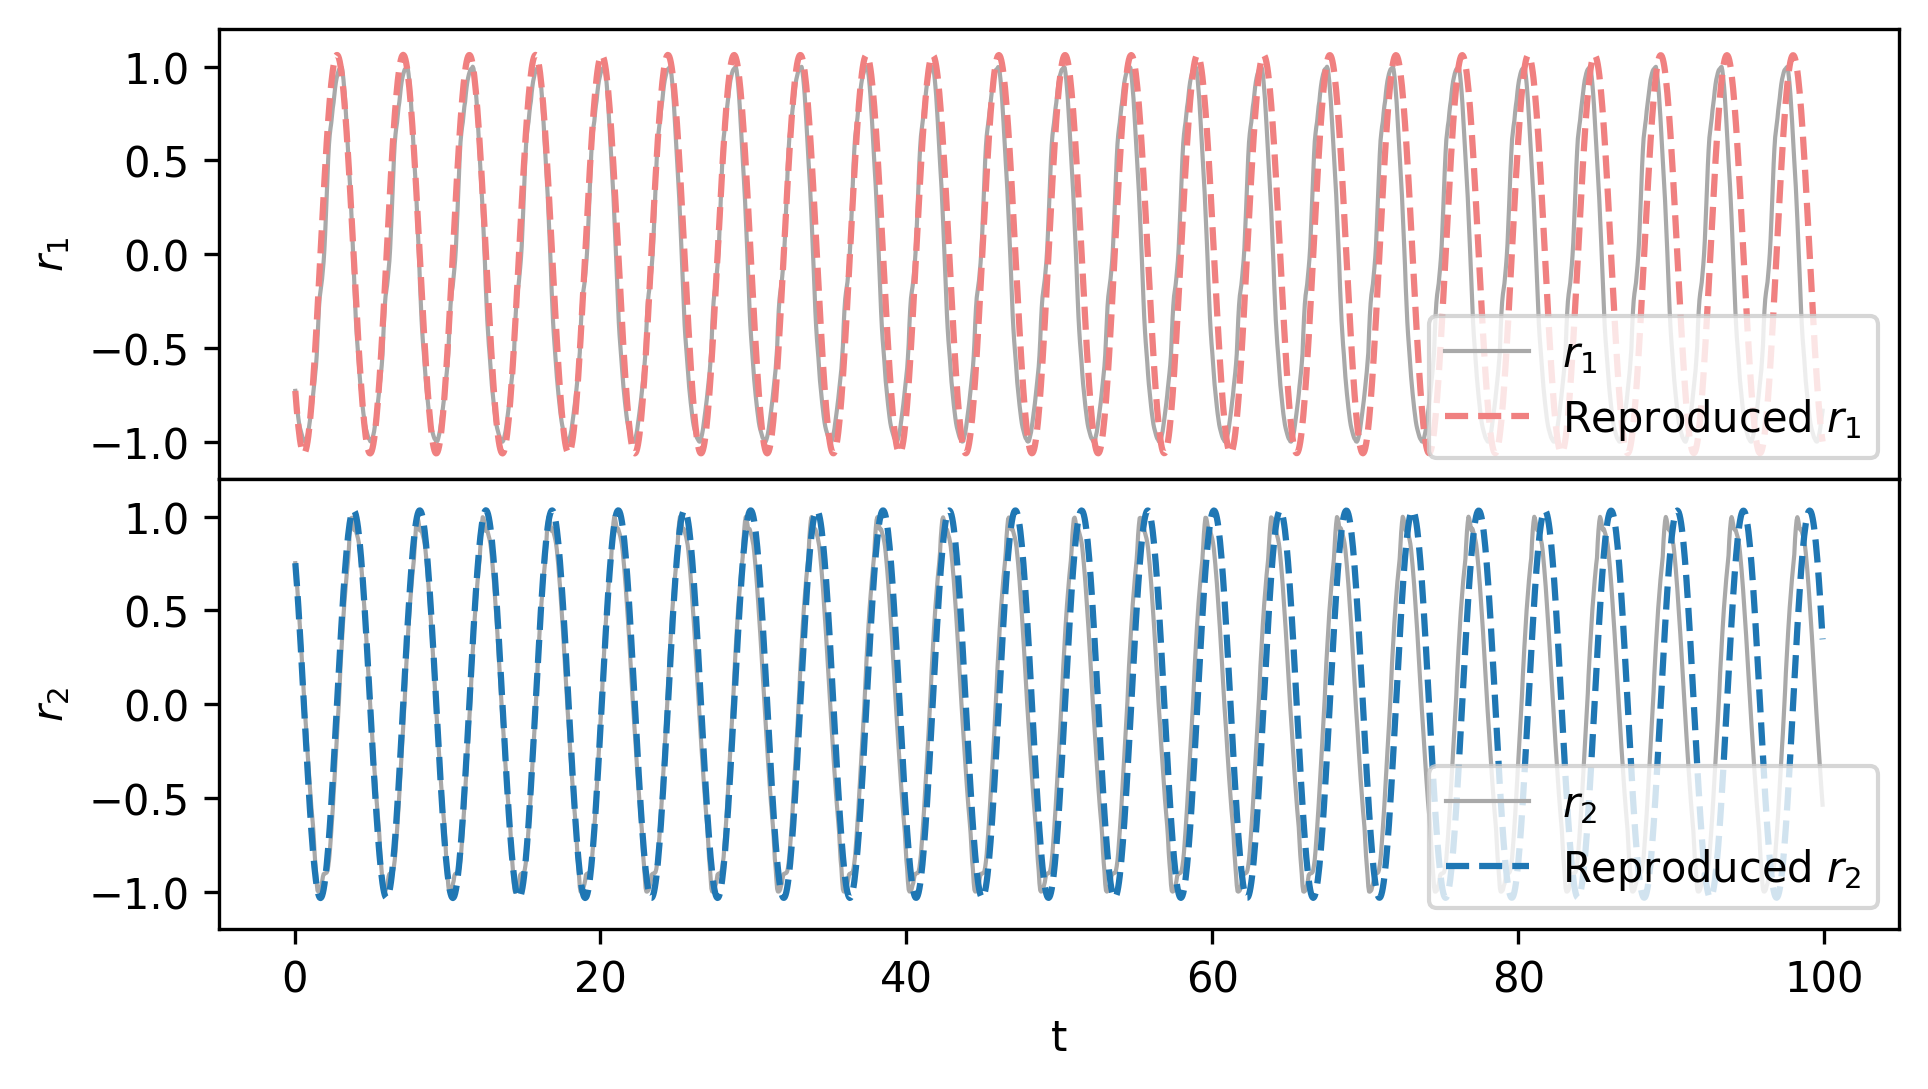

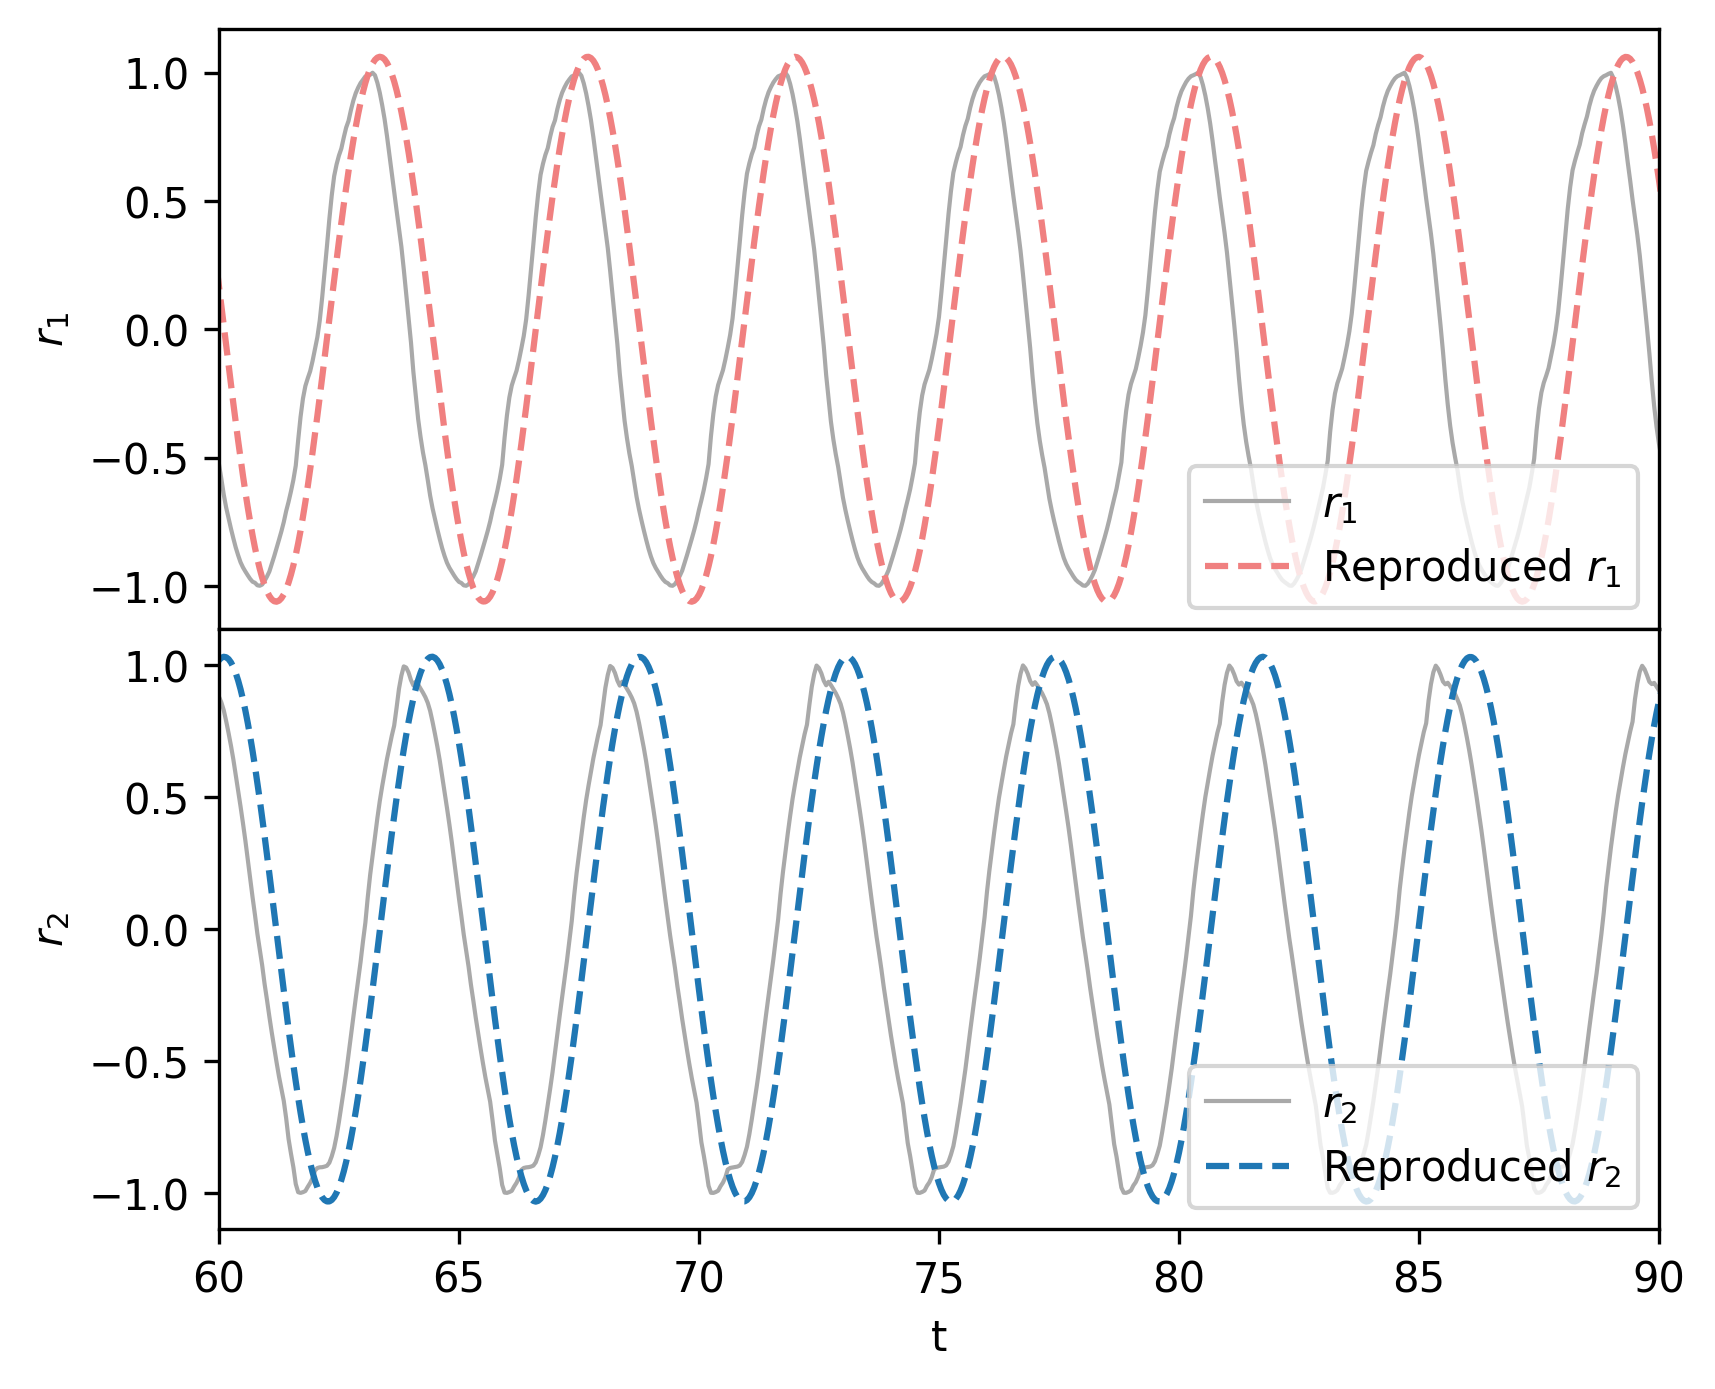

In [ ]:
data = data_sae
ddata = ddata_sae

delta = 3  # 3
# n_ts=2000，u
n_order=3

usesint = True
# tax = np.arange(dtsnap,dtsnap*(n_ts-1)-1e-5,dtsnap)
# fre
usesin = False
uset = True

import warnings
warnings.filterwarnings("ignore") # 忽略不收敛警告

# def AIC(data,vodey,vodet):
# def rms_and_mean(vodey,vodet):   return mean1,rms1

print('mean,rms',rms_and_mean(data.T,taxint))


for n in range(len(alr2)):
  alpha, xi, vodet, vodey, num_r1, num_r2, draw, aic, mean1,rms1,L2_error1,fre1=loop2(n,data,ddata,alr2)
  if vodey.shape[1]==data.shape[0]:
    p1 = stats.pearsonr(vodey[0,:].T, data[:,0])[0]
    p2 = stats.pearsonr(vodey[1,:].T, data[:,1])[0]
    print('PCC',p1,p2)
  print('fre',strouhal(vodey,dt))
  print("n",n,"alpha",alpha)
  RMSE = np.sqrt(((vodey.T-data) ** 2).mean())
  print('RMSE',RMSE)
  print('aic',aic)
  print('mean1,rms1',mean1,rms1)
  print("n",n,"alpha",alpha)
  print(draw)
  print('n_r1:',num_r1, ' n_r2:', num_r2)

  if ~np.isnan(num_r1):

    # Original and reproduced time history

    # fig=plt.figure(dpi=300,figsize=(8,2))
    fig=plt.figure(dpi=300,figsize=(7,3))

    plt.axes([0.1,0.5,0.8,0.5], ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,0],lw=1,label=r'$r_1$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$',color='lightcoral')   #'#1f77b4')
    plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)
    plt.ylabel(r'$r_1$')

    plt.axes([0.1,0.0,0.8,0.5], ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,1],lw=1,label=r'$r_2$',color='darkgray')
    plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$') #,color='royalblue')      #'#ff7f0e')
    plt.legend(loc='lower right')
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    plt.xlabel('t') #',fontsize=20)
    plt.ylabel(r'$r_2$')

    plt.show()

    fig=plt.figure(dpi=300,figsize=(6,4))

    plt.axes([0.1,0.5,0.8,0.5])  #, ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,0],lw=1,label=r'$r_1$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$', color='lightcoral')
    plt.legend(loc='lower right')
    # plt.grid(True)
    plt.xticks([])
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)
    plt.ylabel(r'$r_1$')

    plt.xlim([60,90])
    # plt.xlim([0,30])

    plt.axes([0.1,0.0,0.8,0.5])  #, ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,1],lw=1,label=r'$r_2$',color='darkgray')
    plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$') #,color='#ff7f0e')
    plt.legend(loc='lower right')
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)
    plt.xlabel('t') #',fontsize=20)
    plt.ylabel(r'$r_2$')


    plt.xlim([60,90])
    # plt.xlim([0,30])

    plt.show()

In [ ]:
vodey_sae = cp(vodey)

mean,rms (-0.028741565301841417, 1.4297735725825746)
count_nonzero(xi):  4
PCC 0.971159303762052 0.9721526736866216
n 0 alpha 0.0007
RMSE 0.1756461613416787
aic -5557.2698163328905
mean1,rms1 -0.005616665795313423 1.3849354220017613
n 0 alpha 0.0007
1
n_r1: 2  n_r2: 2


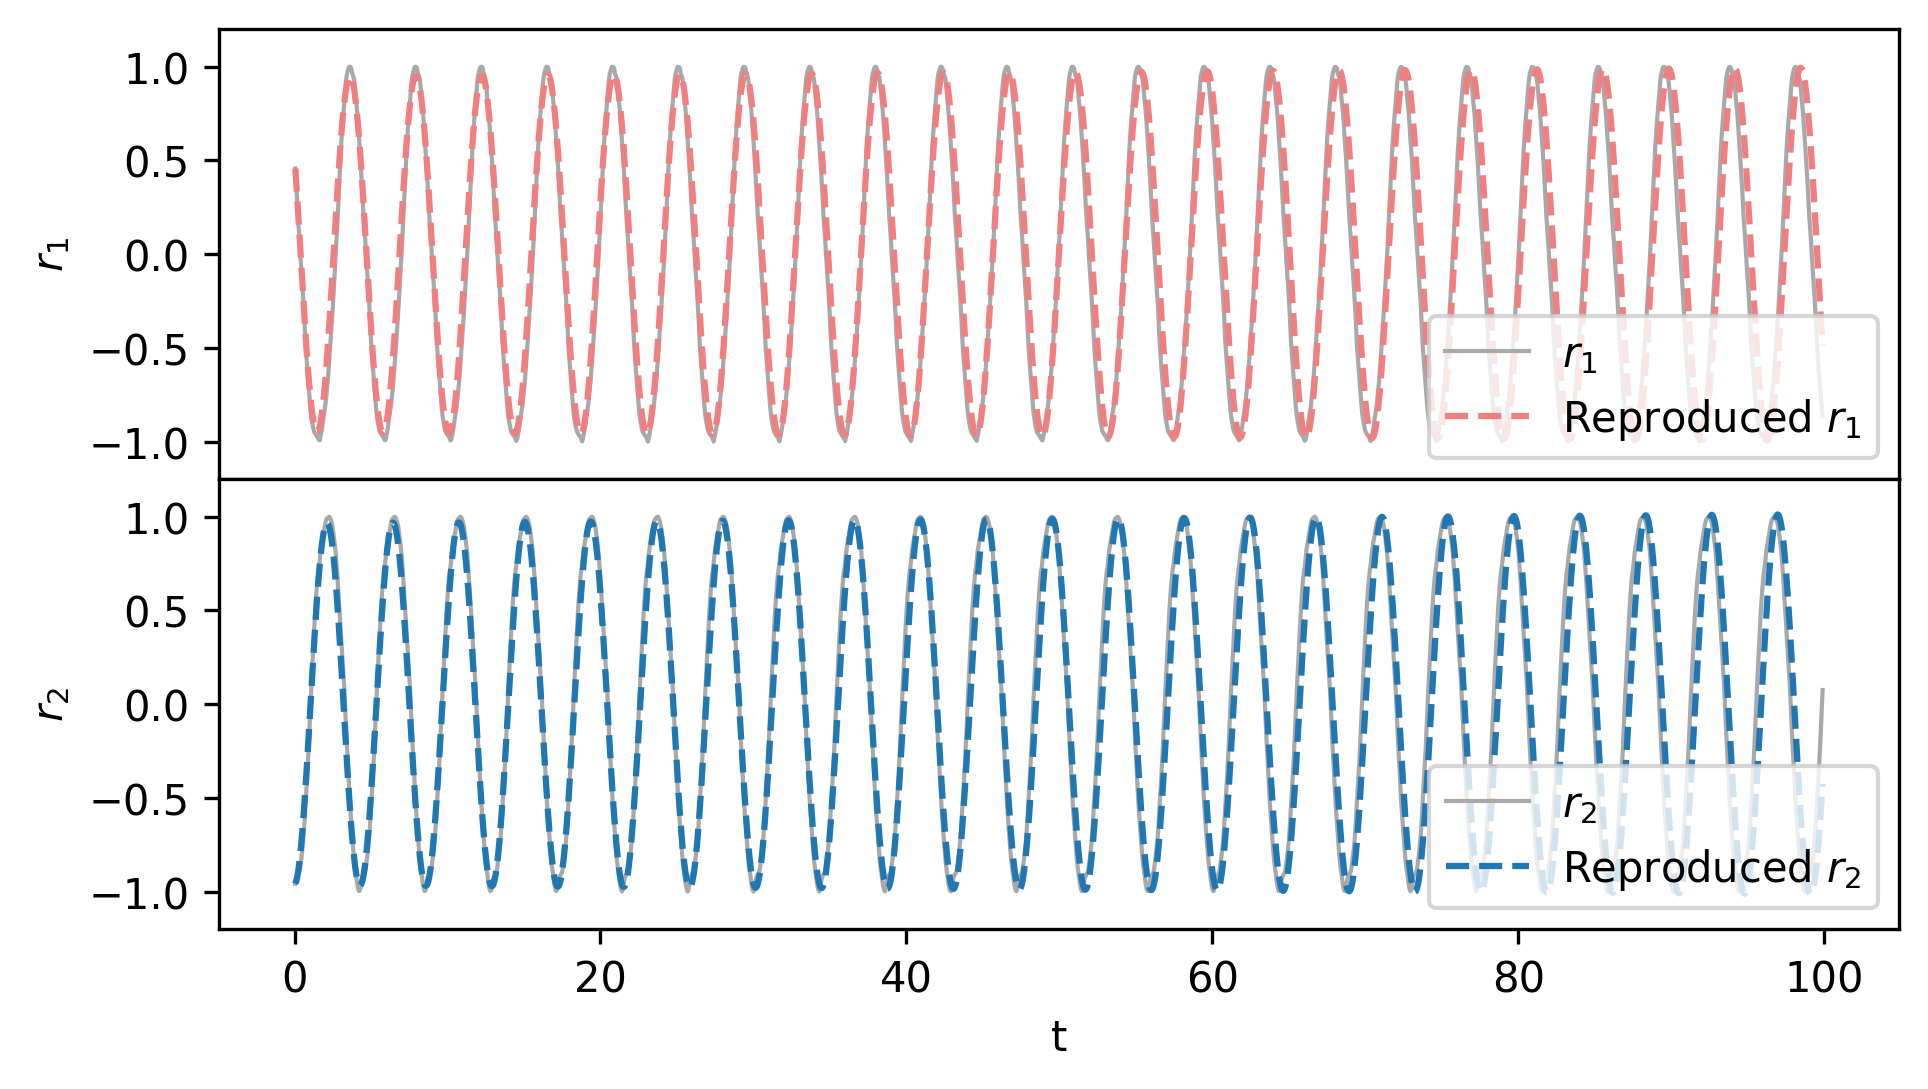

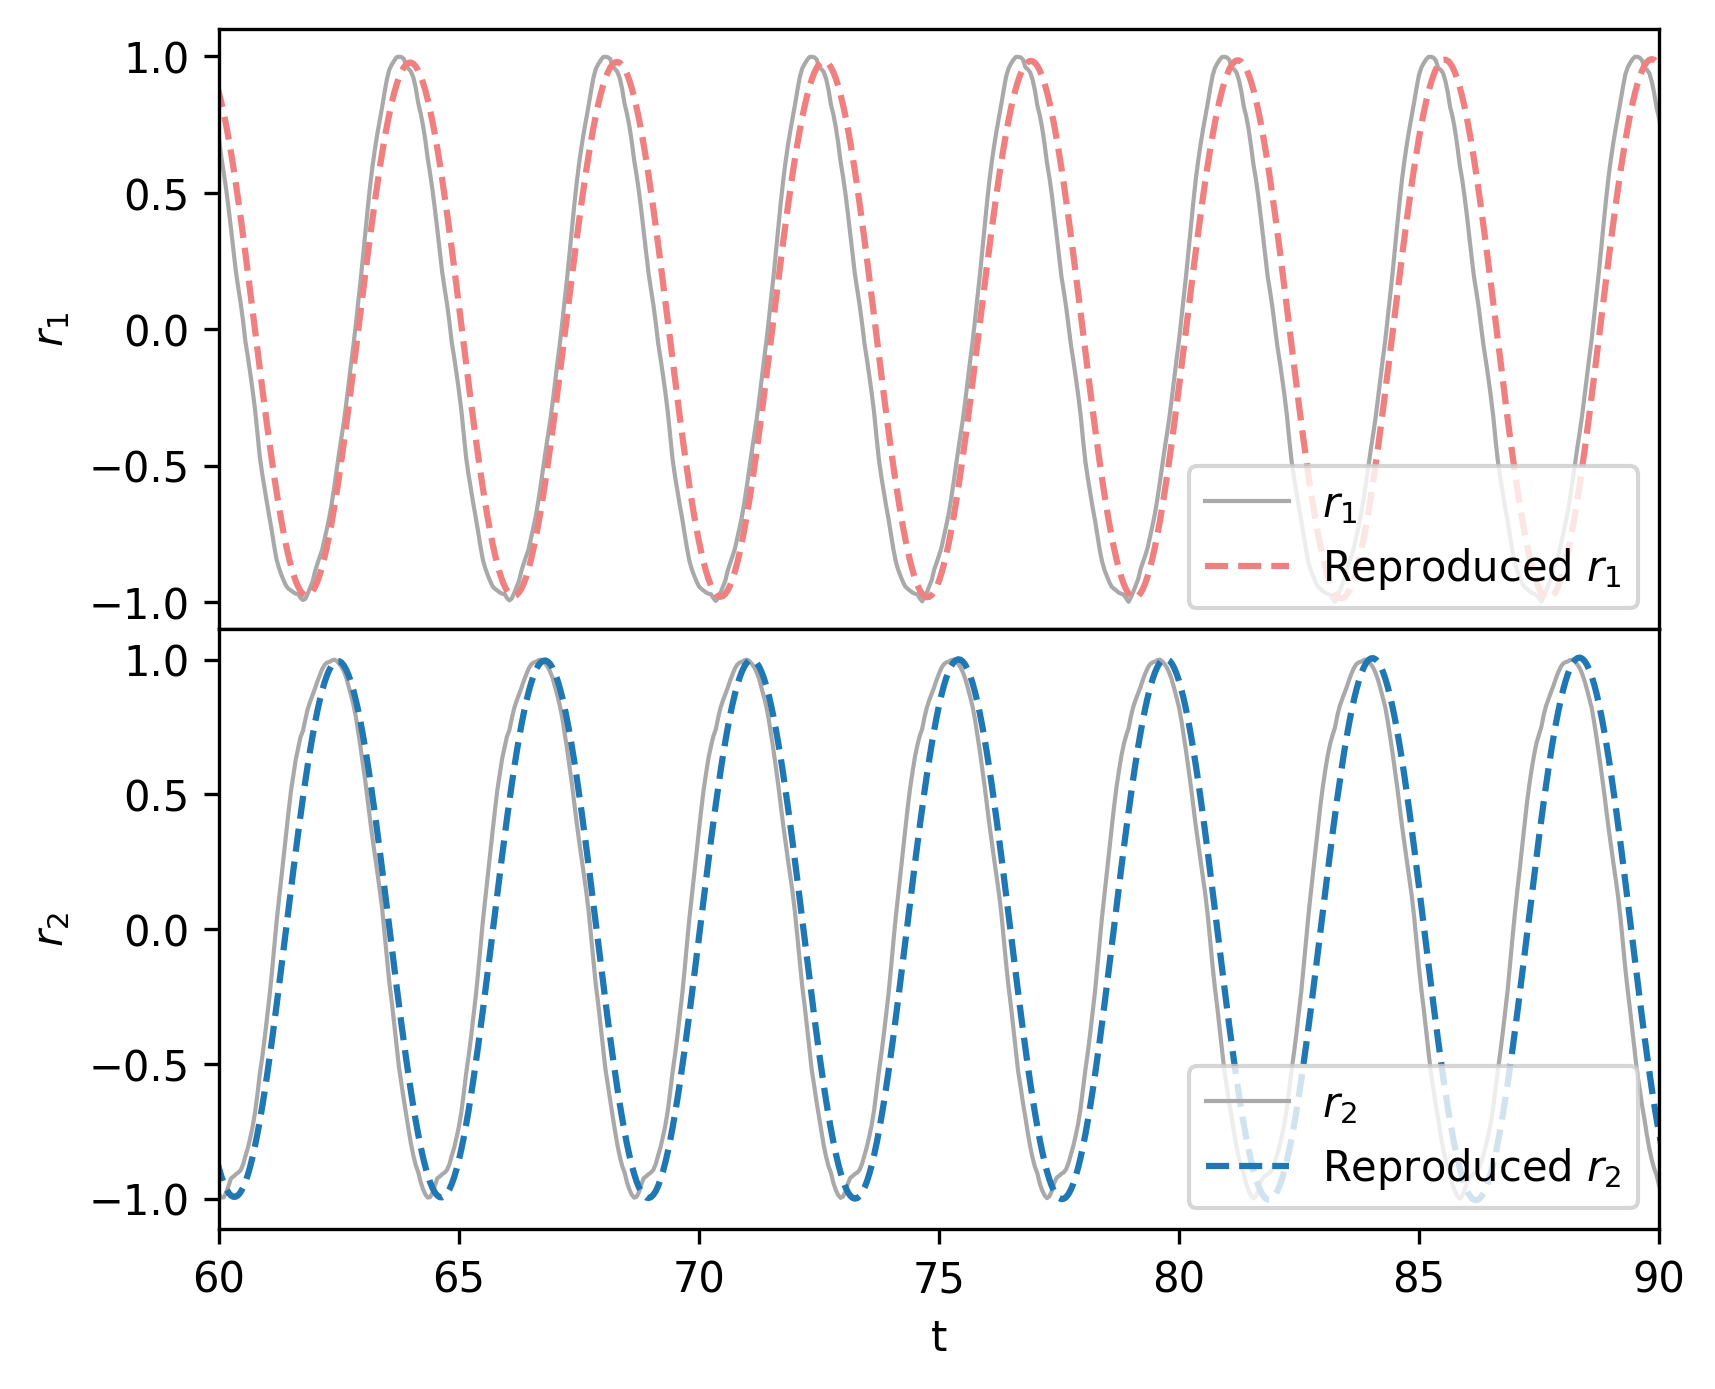

In [ ]:
data = data_sae_pod
ddata = ddata_sae_pod

delta = 2
# n_ts=2000，u
n_order=3

usesint = True
# tax = np.arange(dtsnap,dtsnap*(n_ts-1)-1e-5,dtsnap)
# fre
usesin = False
uset = True

import warnings
warnings.filterwarnings("ignore") # 忽略不收敛警告

# def AIC(data,vodey,vodet):
# def rms_and_mean(vodey,vodet):   return mean1,rms1

print('mean,rms',rms_and_mean(data.T,taxint))


for n in range(len(alr2)):
  alpha, xi, vodet, vodey, num_r1, num_r2, draw, aic, mean1,rms1,L2_error1,fre1=loop2(n,data,ddata,alr2)
  if vodey.shape[1]==data.shape[0]:
    p1 = stats.pearsonr(vodey[0,:].T, data[:,0])[0]
    p2 = stats.pearsonr(vodey[1,:].T, data[:,1])[0]
    print('PCC',p1,p2)
  print("n",n,"alpha",alpha)
  RMSE = np.sqrt(((vodey.T-data) ** 2).mean())
  print('RMSE',RMSE)
  print('aic',aic)
  print('mean1,rms1',mean1,rms1)
  print("n",n,"alpha",alpha)
  print(draw)
  print('n_r1:',num_r1, ' n_r2:', num_r2)

  if ~np.isnan(num_r1):

    # Original and reproduced time history

    # fig=plt.figure(dpi=300,figsize=(8,2))
    fig=plt.figure(dpi=300,figsize=(7,3))

    plt.axes([0.1,0.5,0.8,0.5], ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,0],lw=1,label=r'$r_1$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$',color='lightcoral')   #'#1f77b4')
    plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)
    plt.ylabel(r'$r_1$')

    plt.axes([0.1,0.0,0.8,0.5], ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,1],lw=1,label=r'$r_2$',color='darkgray')
    plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$') #,color='royalblue')      #'#ff7f0e')
    plt.legend(loc='lower right')
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    plt.xlabel('t') #',fontsize=20)
    plt.ylabel(r'$r_2$')

    plt.show()

    fig=plt.figure(dpi=300,figsize=(6,4))

    plt.axes([0.1,0.5,0.8,0.5])  #, ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,0],lw=1,label=r'$r_1$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r_1$', color='lightcoral')
    plt.legend(loc='lower right')
    # plt.grid(True)
    plt.xticks([])
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)
    plt.ylabel(r'$r_1$')

    plt.xlim([60,90])

    plt.axes([0.1,0.0,0.8,0.5])  #, ylim=(-1.2,1.2))
    plt.plot(taxint,data[:,1],lw=1,label=r'$r_2$',color='darkgray')
    plt.plot(vodet,vodey[1,:],'--',label='Reproduced $r_2$') #,color='#ff7f0e')
    plt.legend(loc='lower right')
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    # plt.xlabel(r'$t$',fontsize=20)
    plt.xlabel('t') #',fontsize=20)
    plt.ylabel(r'$r_2$')


    plt.xlim([60,90])

    plt.show()

In [ ]:
vodey_sae_pod = cp(vodey)

##### show equ

In [ ]:
from process import *

In [ ]:
print(xi)
powers = Omega(2,3)
for i in range(len(powers)):
  print(powers[i])

[[-0.    -0.   ]
 [ 1.764 -1.05 ]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [ 1.051 -1.829]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [-0.     0.   ]
 [-0.     0.   ]]
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(3, 0)


In [ ]:
def odeterm(arr,k):
  term = ""
  for i in range(k):
    if arr[i]==0: term = term
    elif arr[i]==1: term = term+"r_"+str(i+1)
    elif arr[i]>1: term = term+"r_"+str(i+1)+"^{"+str(arr[i])+"}"
  return term

# print(odeterm(powers[25],4))
# 'x^2'=odeterm(powers[i])

def show_eqs(xi,n_order,usesin=False,uset=False,usesint=False):
  k = xi.shape[1]
  odeterms = []
  print("k",k)

  usfl = 0
  # p = 0

  powers = Omega(k,n_order)

  if usesin:
    usfl = 2*k
  if usesint:
    usfl = usfl+2
  if uset:
    usfl = usfl+n_order

  term_num = usfl+len(powers)

  if term_num != xi.shape[0]:
    print("term numbers error!")
    return

  for i in range(k):
    p = 0
    eqs_term = xi[:,i]
    eqs = "\\frac{r_"+str(i+1)+"}{dt}="
    for ii in range(len(powers)):
      if eqs_term[ii]==0: eqs=eqs+""
      elif eqs_term[ii]>0: eqs=eqs+"+"+str(eqs_term[ii])+odeterm(powers[ii],k)
      else: eqs=eqs+str(eqs_term[ii])+odeterm(powers[ii],k)
      p = p+1
    if usesin:
      for j in range(k):
        if eqs_term[p]!=0: eqs=eqs+str(eqs_term[p])+"sin(r_"+str(k)+")"
        if eqs_term[p+1]!=0: eqs=eqs+str(eqs_term[p+1])+"cos(r_"+str(k)+")"
        p = p+2
    if uset:
      for jj in range(n_order):
        if eqs_term[p]!=0: eqs=eqs+str(eqs_term[p])+"t^"+str(jj+1)
        p = p+1
    if usesint:
      if eqs_term[p]!=0: eqs=eqs+str(eqs_term[p])+"sin("+str(fre)+"t^"+str(jj+1)+")"
      if eqs_term[p+1]!=0: eqs=eqs+str(eqs_term[p+1])+"cos("+str(fre)+"t^"+str(jj+1)+")"
      p = p+2
    print(eqs)
  return

In [ ]:
uset = True
usesin = False
usesint = True

In [ ]:
print(xi.shape)

(15, 2)


In [ ]:
show_eqs(xi,3,usesin,uset,usesint)

k 2
\frac{r_1}{dt}=+1.764r_2+1.051r_1
\frac{r_2}{dt}=-1.05r_2-1.829r_1


### sae+pod - decoder

In [ ]:
r_min11 = np.load('./r_min_sae1.npy')
r_max11 = np.load('./r_max_sae1.npy')
r_min12 = np.load('./r_min_sae2.npy')
r_max12 = np.load('./r_max_sae2.npy')

In [ ]:
re_r1 = vodey_sae.T
for i in range(len(re_r1)):
  # re_r1[i,:] = (re_r1[i,:]*(r_max12-r_min12)+r_max12+r_min12)/2
  re_r1[i,:] = (re_r1[i,:]*(r_max11-r_min11)+r_max11+r_min11)/2
print(re_r1.shape)

(1998, 2)


In [ ]:
re_r2 = sae_pca.inverse_transform(re_r1)

decoded

In [ ]:
decor = decoder_sae.predict(re_r2,verbose=1)
print(decor.shape)

63/63 [==============================] - 3s 42ms/step
(1998, 8192)


In [ ]:
decof = cp(decor)
decof = decof.reshape((len(decof),Nx,Ny))
# decof = decof.reshape((len(decof),Nx,Ny,2))
print(decof.shape)

(1998, 128, 64)


In [ ]:
decoa = np.empty_like(decof)
for i in range(0,len(decoa)):
  # decoa[i,:,:,:] = decof[i,:,:,:]+min
  decoa[i,:,:] = decof[i,:,:]+min

In [ ]:
print(np.max(decof))
print(np.min(decof))

2.044931
-0.18063149


In [ ]:
deco = np.empty_like(decof)
for i in range(0,len(deco)):
  # deco[i,:,:,:] = decoa[i,:,:,:]+X_avg
  deco[i,:,:] = decoa[i,:,:]+X_avg
print(deco.shape)

(1998, 128, 64)


In [ ]:
deco_sae = deco
# np.save('./deco_sae.npy',deco_sae)
# deco_sae = np.load('./deco_sae.npy')

### deco

In [ ]:
deco_sae_pod = np.load('./deco_sae_pod.npy')

0s


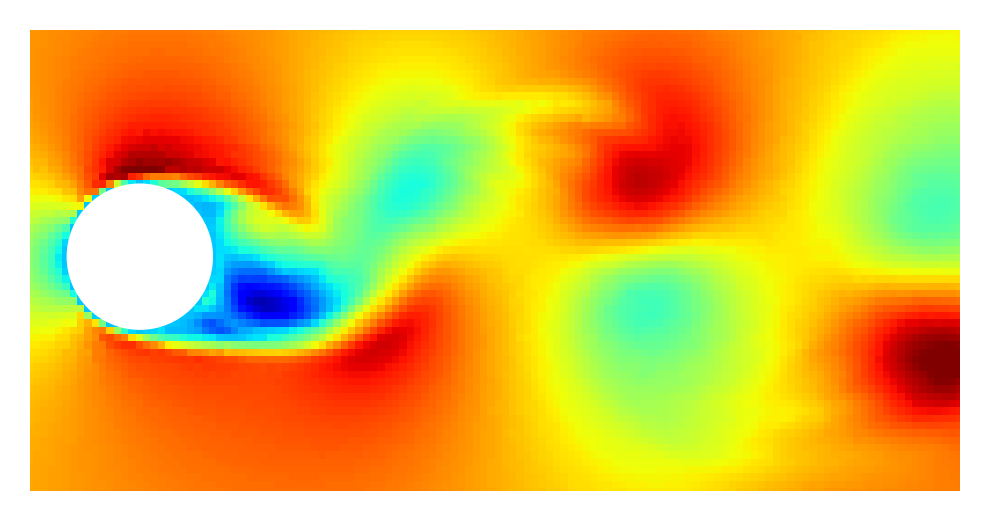

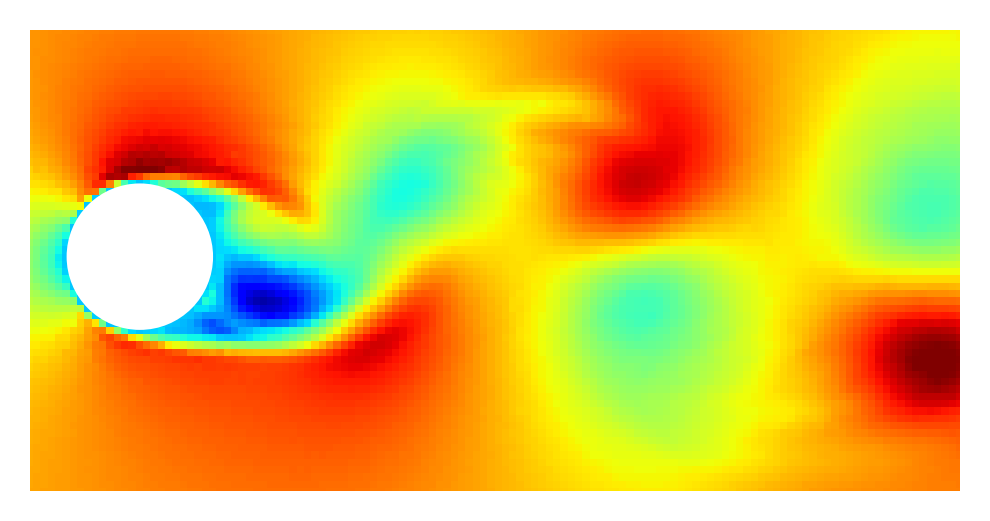

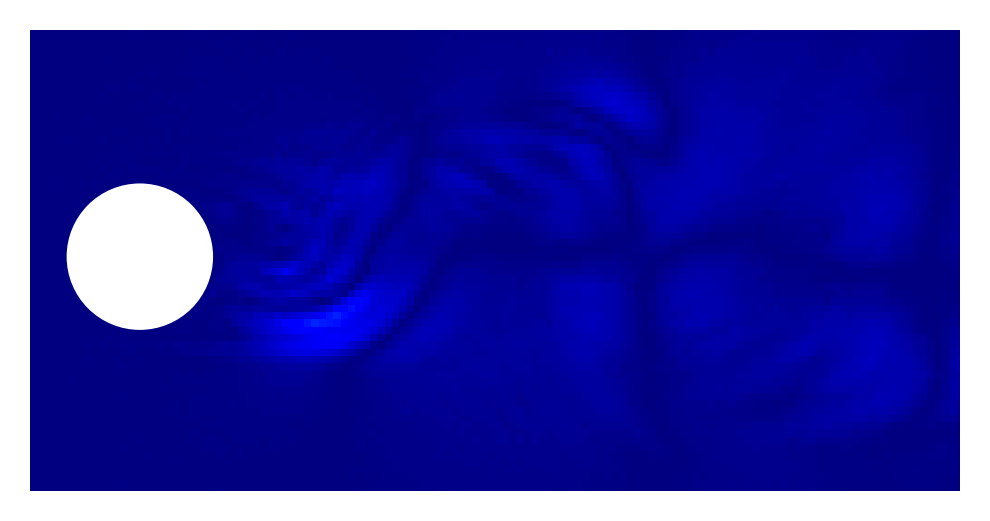

In [ ]:
print('0s')
ttt = 0
contour(X[TT+ttt,:,:],'jet',[-0.8,1.7],xn,yn)
contour(deco_sae_pod[ttt,:,:],'jet',[-0.8,1.7],xn,yn)
contour(abs(X[ttt,:,:]-deco_sae_pod[ttt,:,:]),'jet',[0,0.9],xn,yn)

27.5s


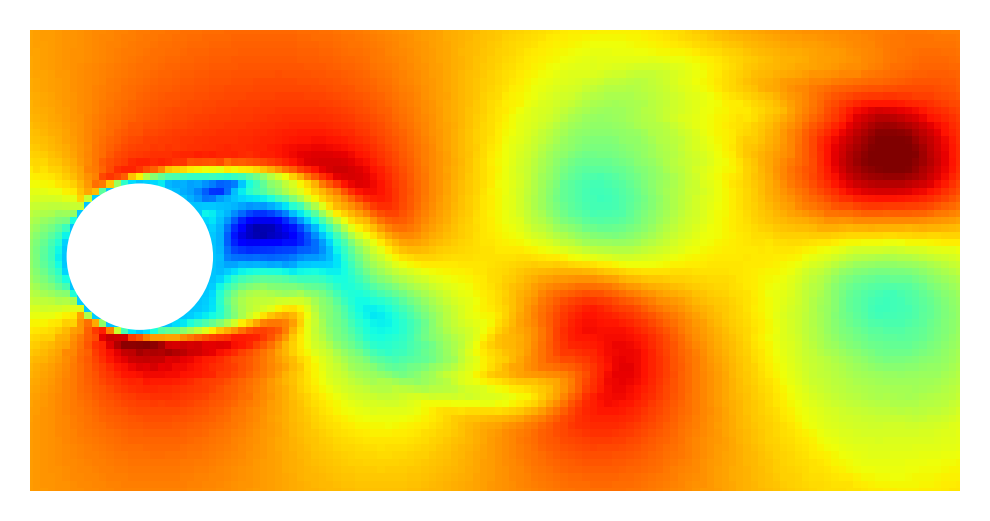

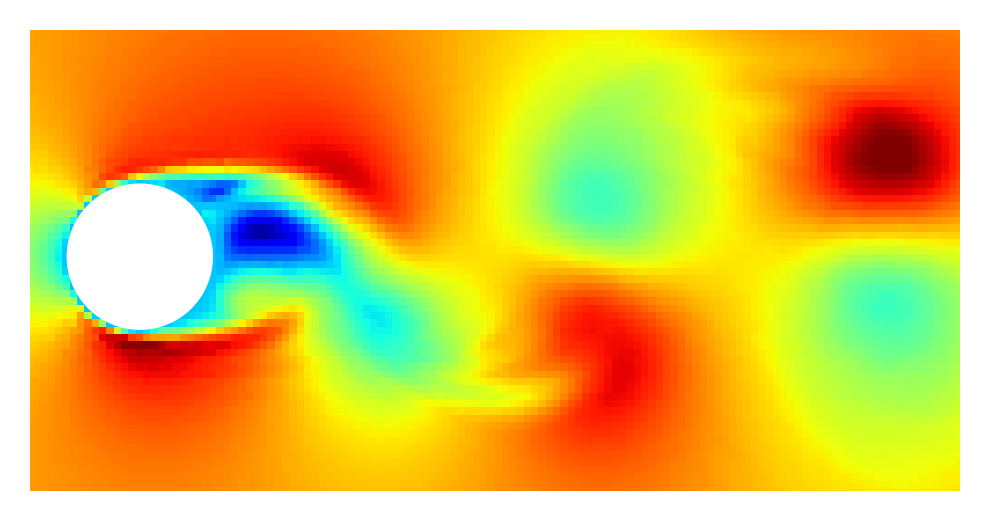

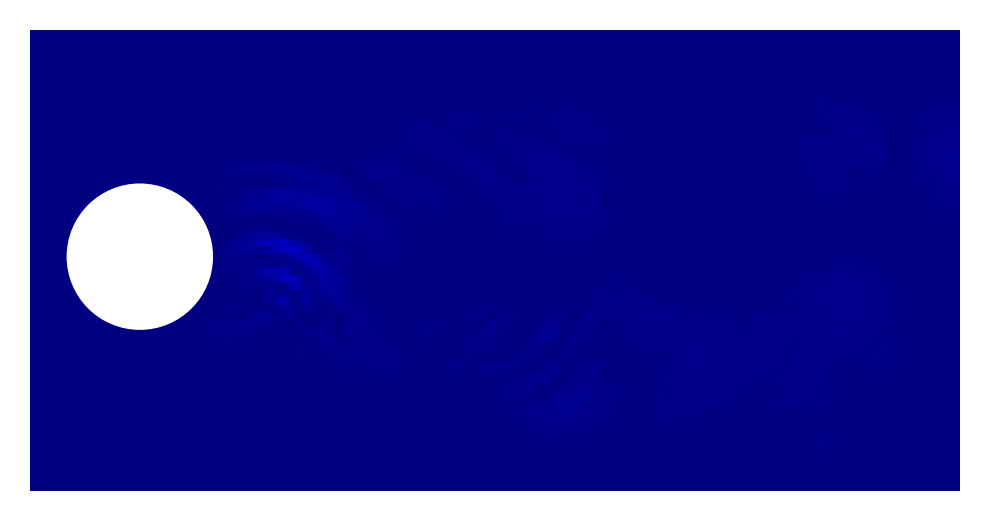

In [ ]:
print('27.5s')
ttt = 550
contour(X[ttt,:,:],'jet',[-0.8,1.7],xn,yn)
contour(deco_sae_pod[ttt,:,:],'jet',[-0.8,1.7],xn,yn)
contour(abs(X[ttt,:,:]-deco_sae_pod[ttt,:,:]),'jet',[0,0.9],xn,yn)

75s


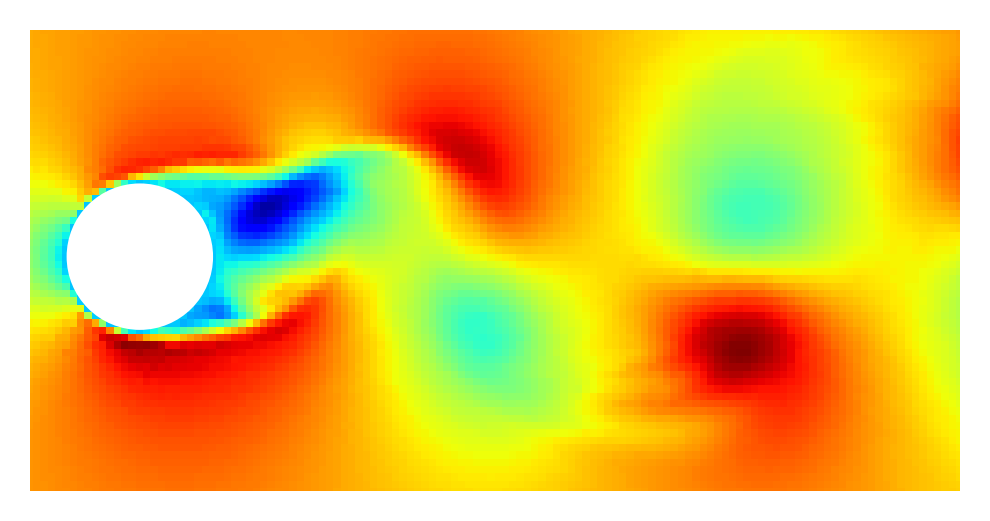

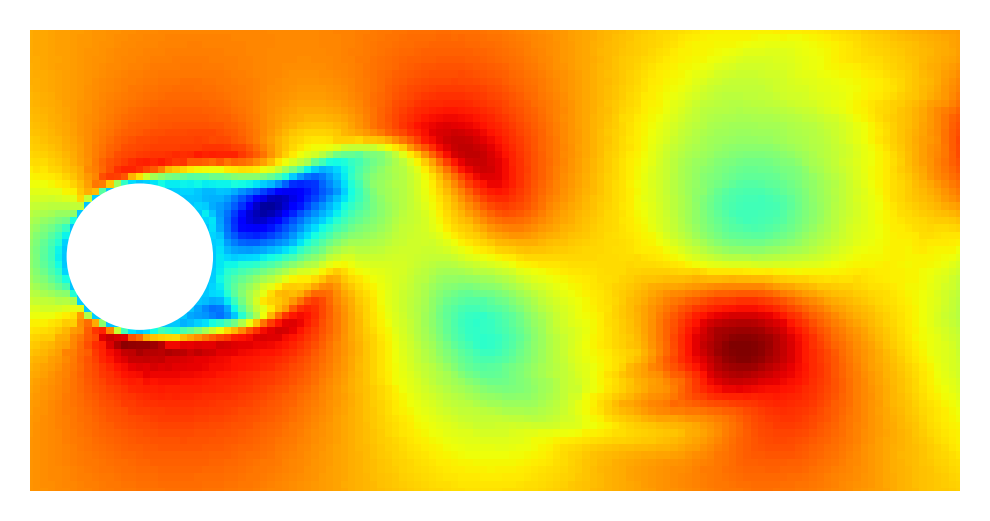

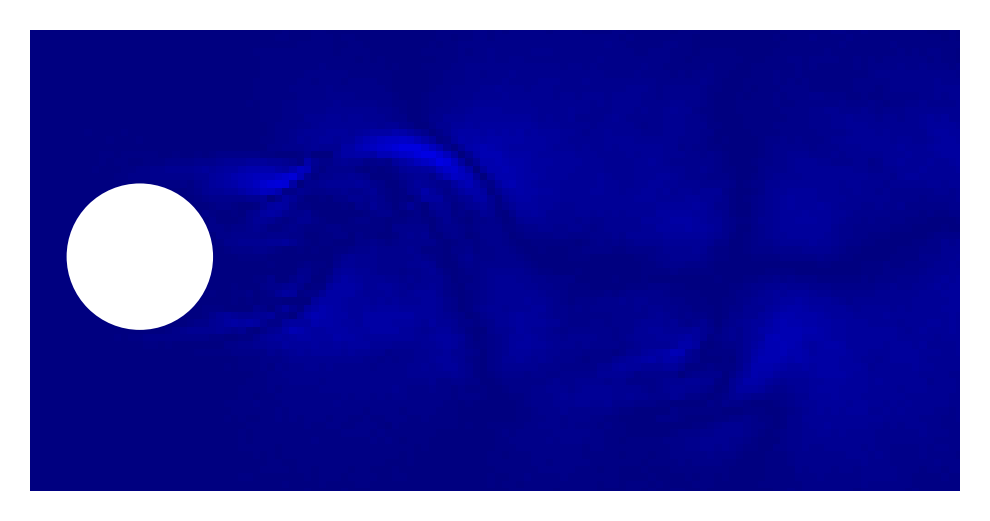

In [ ]:
print('75s')
ttt = 1520
contour(X[ttt,:,:],'jet',[-0.8,1.7],xn,yn)
contour(deco_sae_pod[ttt,:,:],'jet',[-0.8,1.7],xn,yn)
contour(abs(X[ttt,:,:]-deco_sae_pod[ttt,:,:]),'jet',[0,0.65],xn,yn)

### comparing

In [ ]:
value = cp(X[1:1999])
print(deco_sae.shape)
print(deco_sae_pod.shape)

value = value.reshape((len(value),128*64))
deco1 = deco_sae.reshape((1998,128*64))
deco2 = deco_sae_pod.reshape((1998,128*64))

(1998, 128, 64)
(1998, 128, 64)


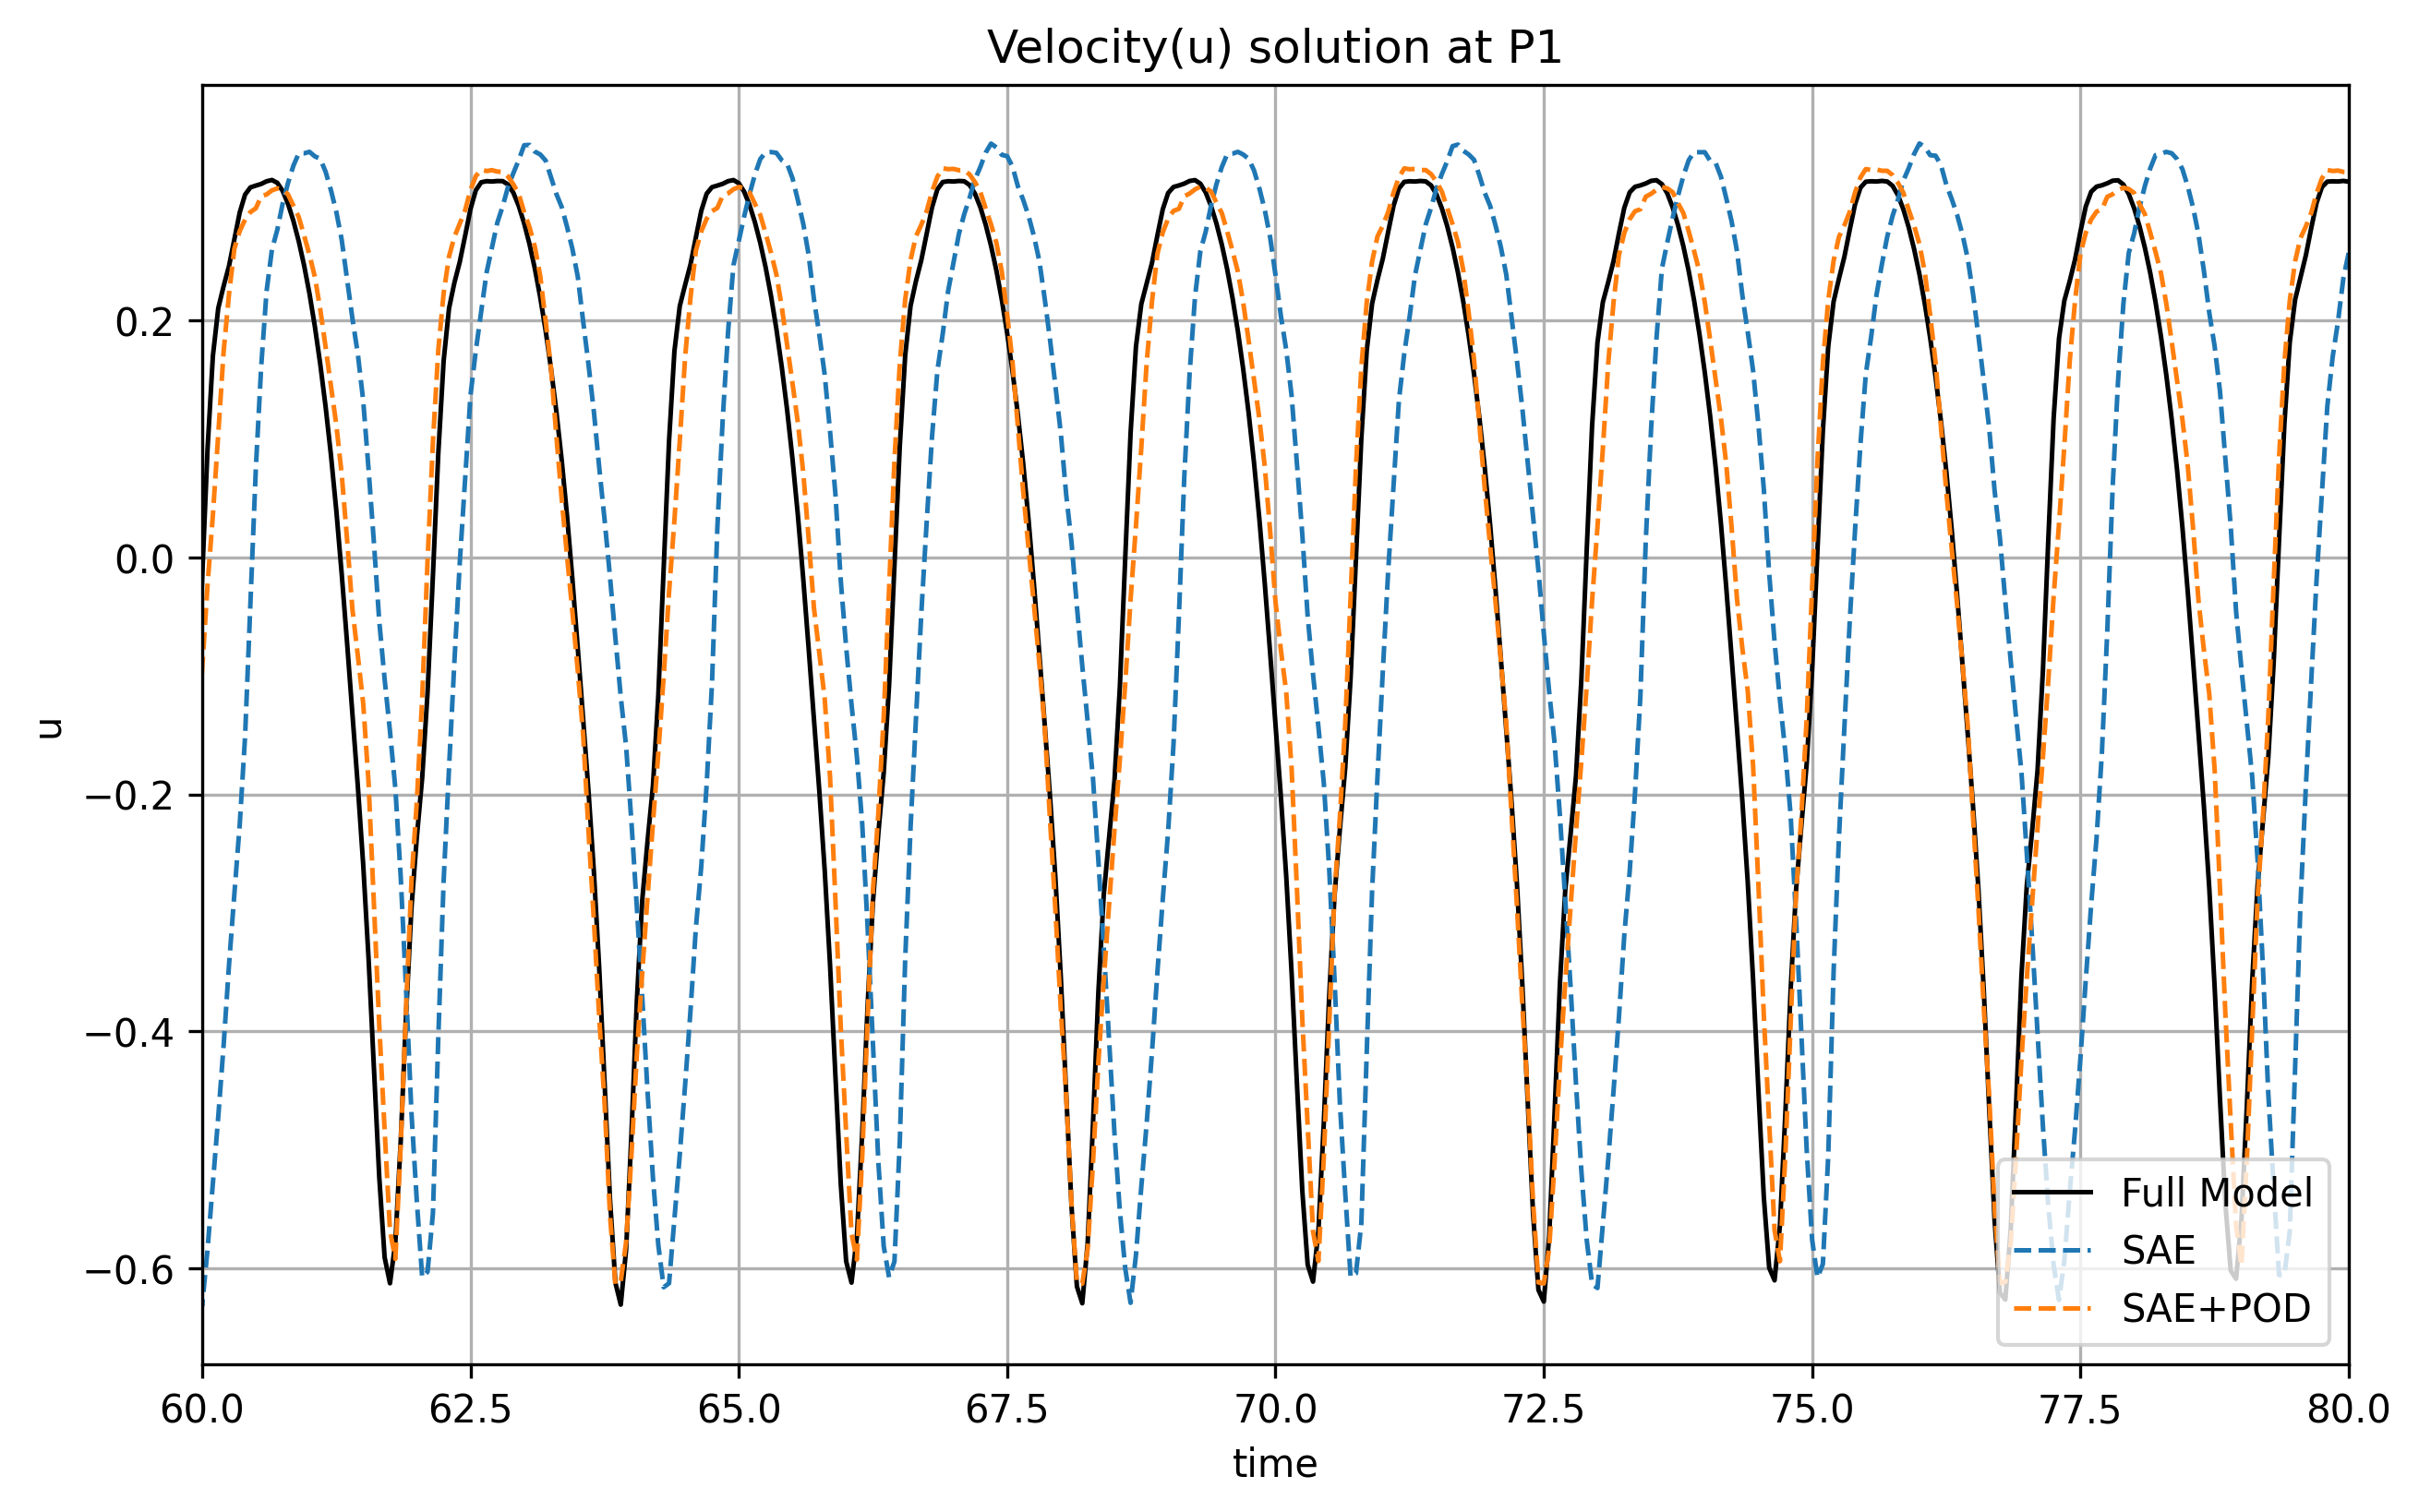

In [ ]:
fig=plt.figure(dpi=300,figsize=(10,6))
pt1 = 2272
plt.plot(taxint[:],value[:,pt1],color='k',lw=1.2,label='Full Model')
plt.plot(taxint,deco1[:,pt1], '--',lw=1.2,label='SAE')
plt.plot(taxint[:],deco2[:,pt1], '--',lw=1.2,label='SAE+POD') #,color='royalblue')      #'#ff7f0e')
plt.legend(loc='lower right')
plt.xlim([60,80])
plt.xlabel('time')
plt.ylabel('u')
plt.title('Velocity(u) solution at P1')
plt.grid()

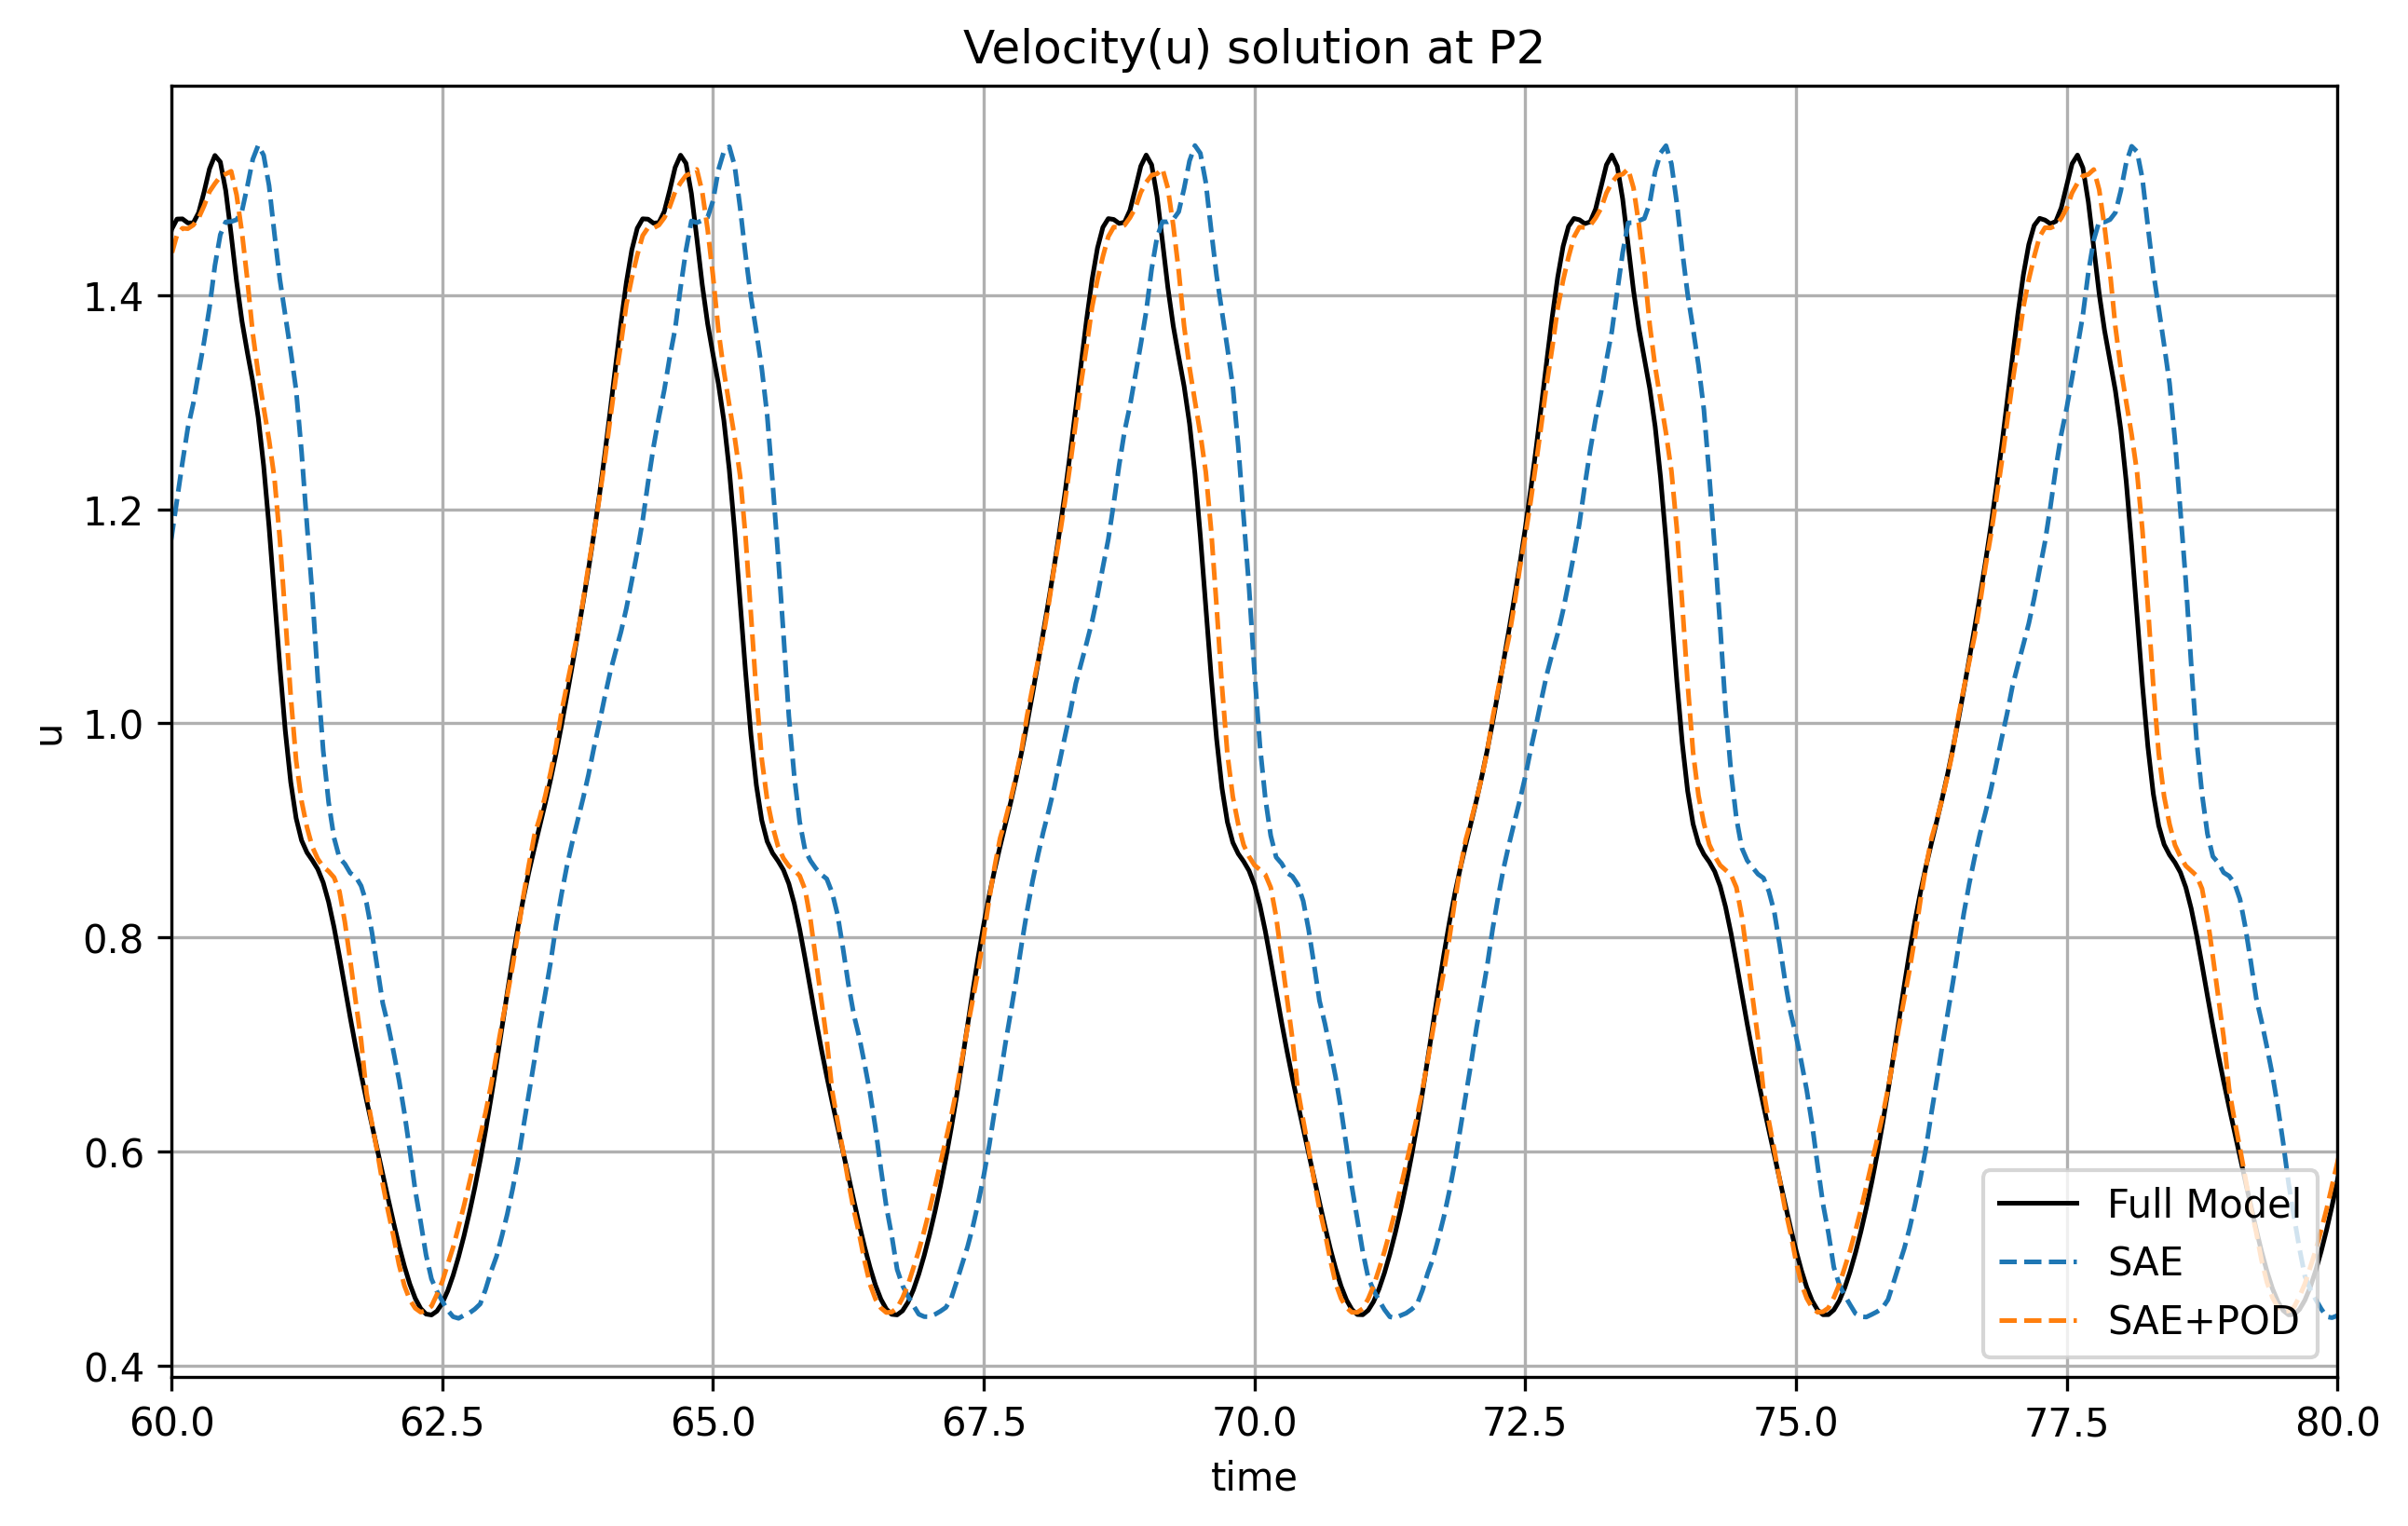

In [ ]:
fig=plt.figure(dpi=300,figsize=(10,6))
pt1 = 5486
plt.plot(taxint[:],value[:,pt1],color='k',lw=1.2,label='Full Model')
plt.plot(taxint,deco1[:,pt1], '--',lw=1.2,label='SAE')
plt.plot(taxint[:],deco2[:,pt1], '--',lw=1.2,label='SAE+POD') #,color='royalblue')      #'#ff7f0e')
plt.legend(loc='lower right')
plt.xlim([60,80])
plt.xlabel('time')
plt.ylabel('u')
plt.title('Velocity(u) solution at P2')
plt.grid()

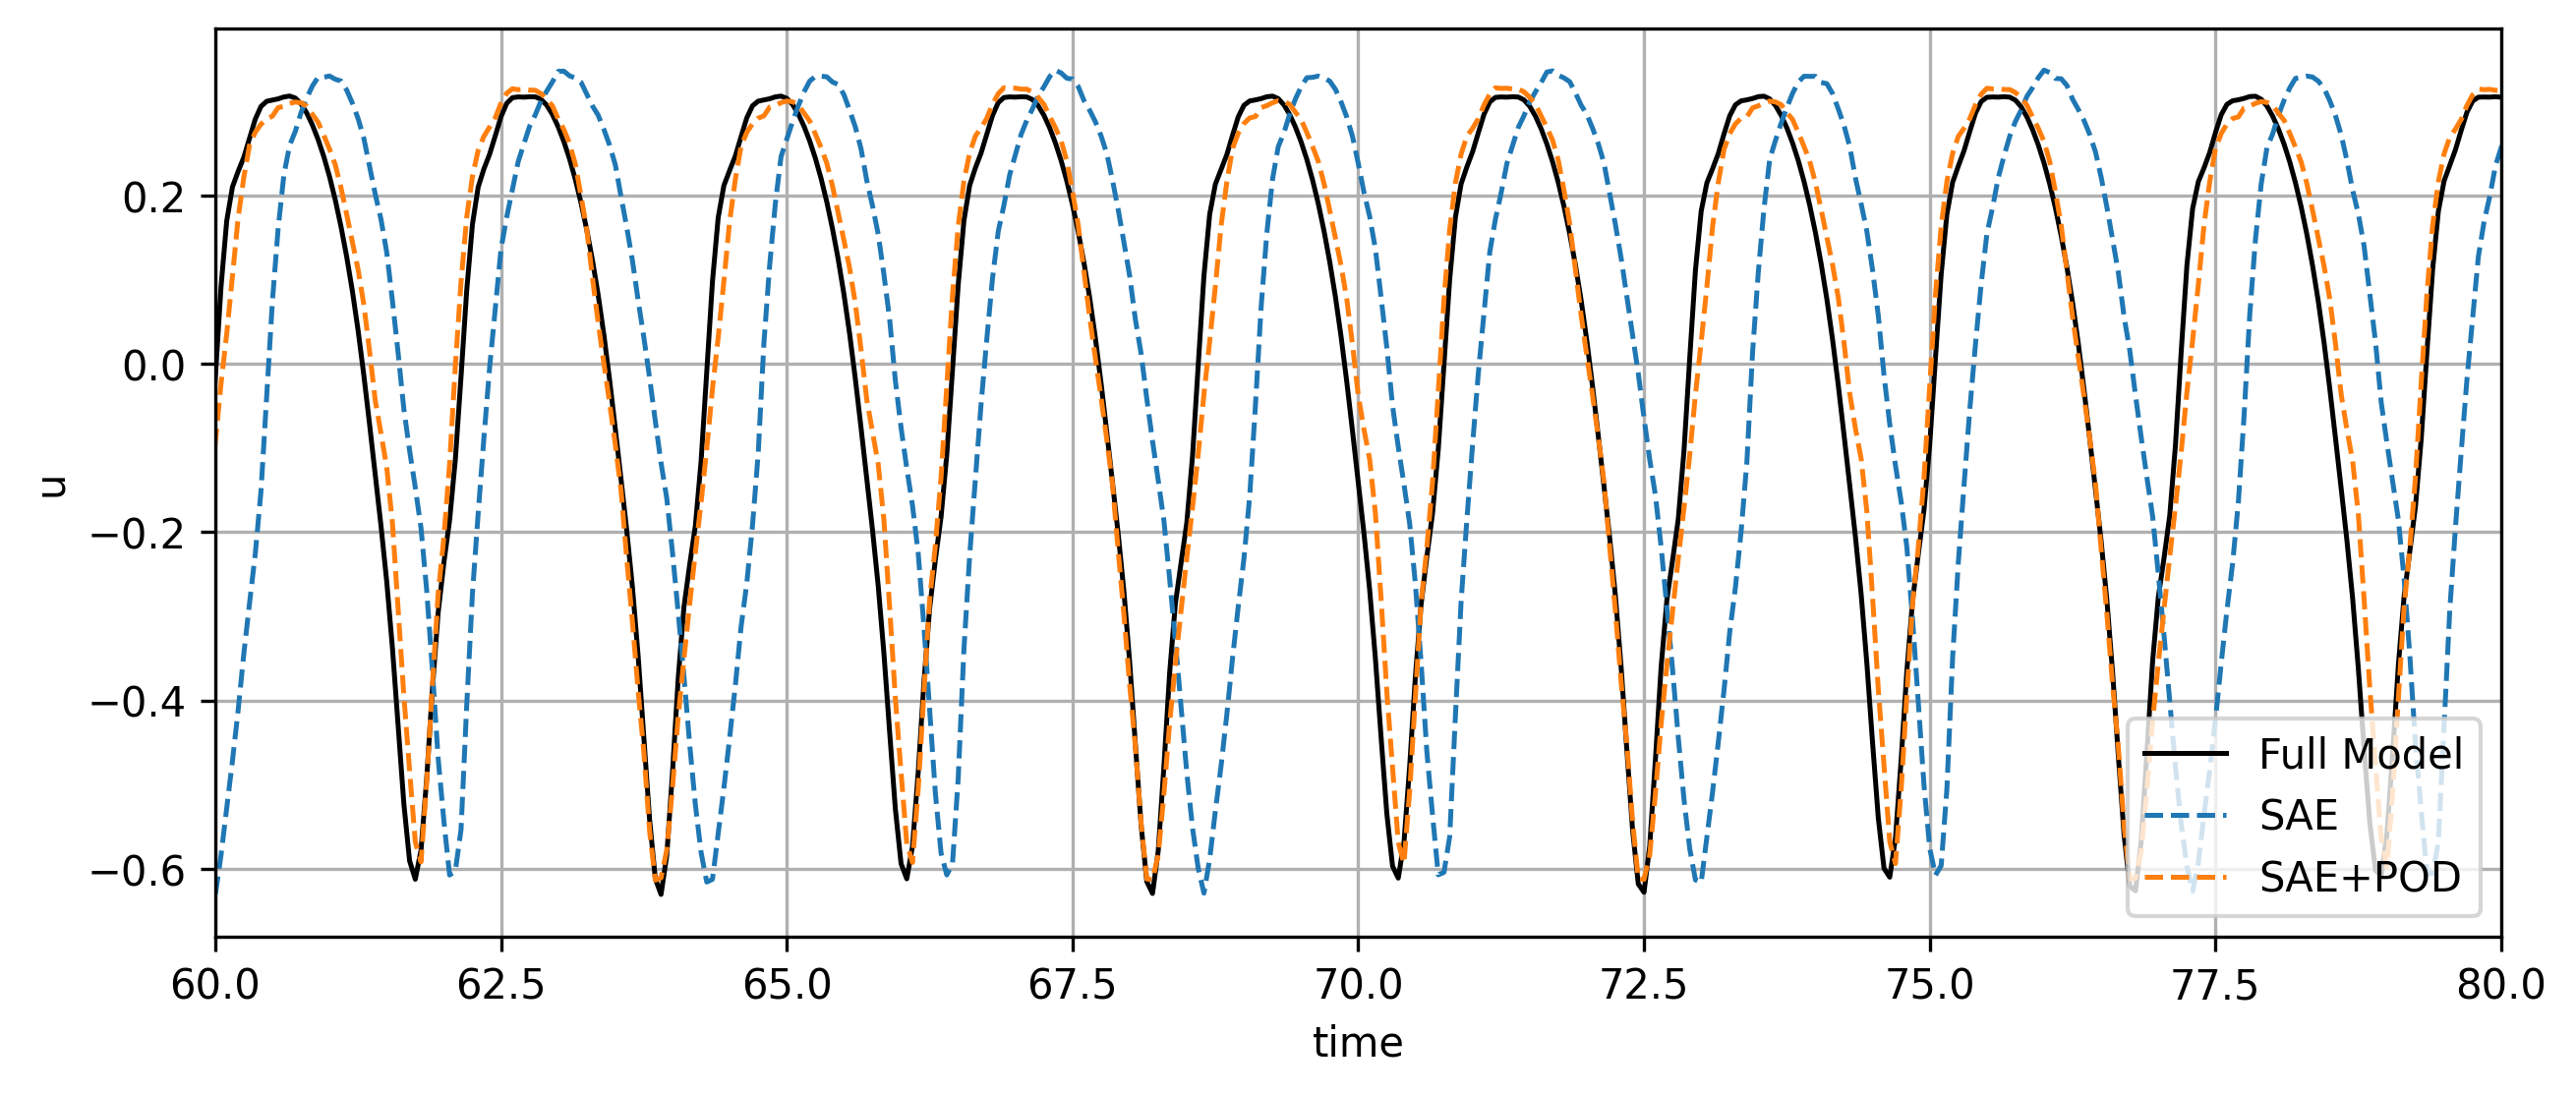

In [ ]:
fig=plt.figure(dpi=300,figsize=(10,4))
pt1 = 2272
plt.plot(taxint[:],value[:,pt1],color='k',lw=1.2,label='Full Model')
plt.plot(taxint,deco1[:,pt1], '--',lw=1.2,label='SAE')
plt.plot(taxint[:],deco2[:,pt1], '--',lw=1.2,label='SAE+POD') #,color='royalblue')      #'#ff7f0e')
plt.legend(loc='lower right')
plt.xlim([60,80])
plt.xlabel('time')
plt.ylabel('u')
# plt.title('velocity vary in a partcicular point')
plt.grid()

In [ ]:
value = cp(X[1:1999])
print(deco_sae.shape)
print(deco_sae_pod.shape)

value = value.reshape((len(value),128*64))
deco1 = deco_sae.reshape((1998,128*64))
deco2 = deco_sae_pod.reshape((1998,128*64))

(1998, 128, 64)
(1998, 128, 64)


In [ ]:
pcc_sae = np.zeros((len(deco),))
pcc_sae_pod = np.zeros((len(deco),))
for i in range(len(deco)):
  pcc_sae[i] = stats.pearsonr(deco1[i,:], value[i,:])[0]
  pcc_sae_pod[i] = stats.pearsonr(deco2[i,:], value[i,:])[0]

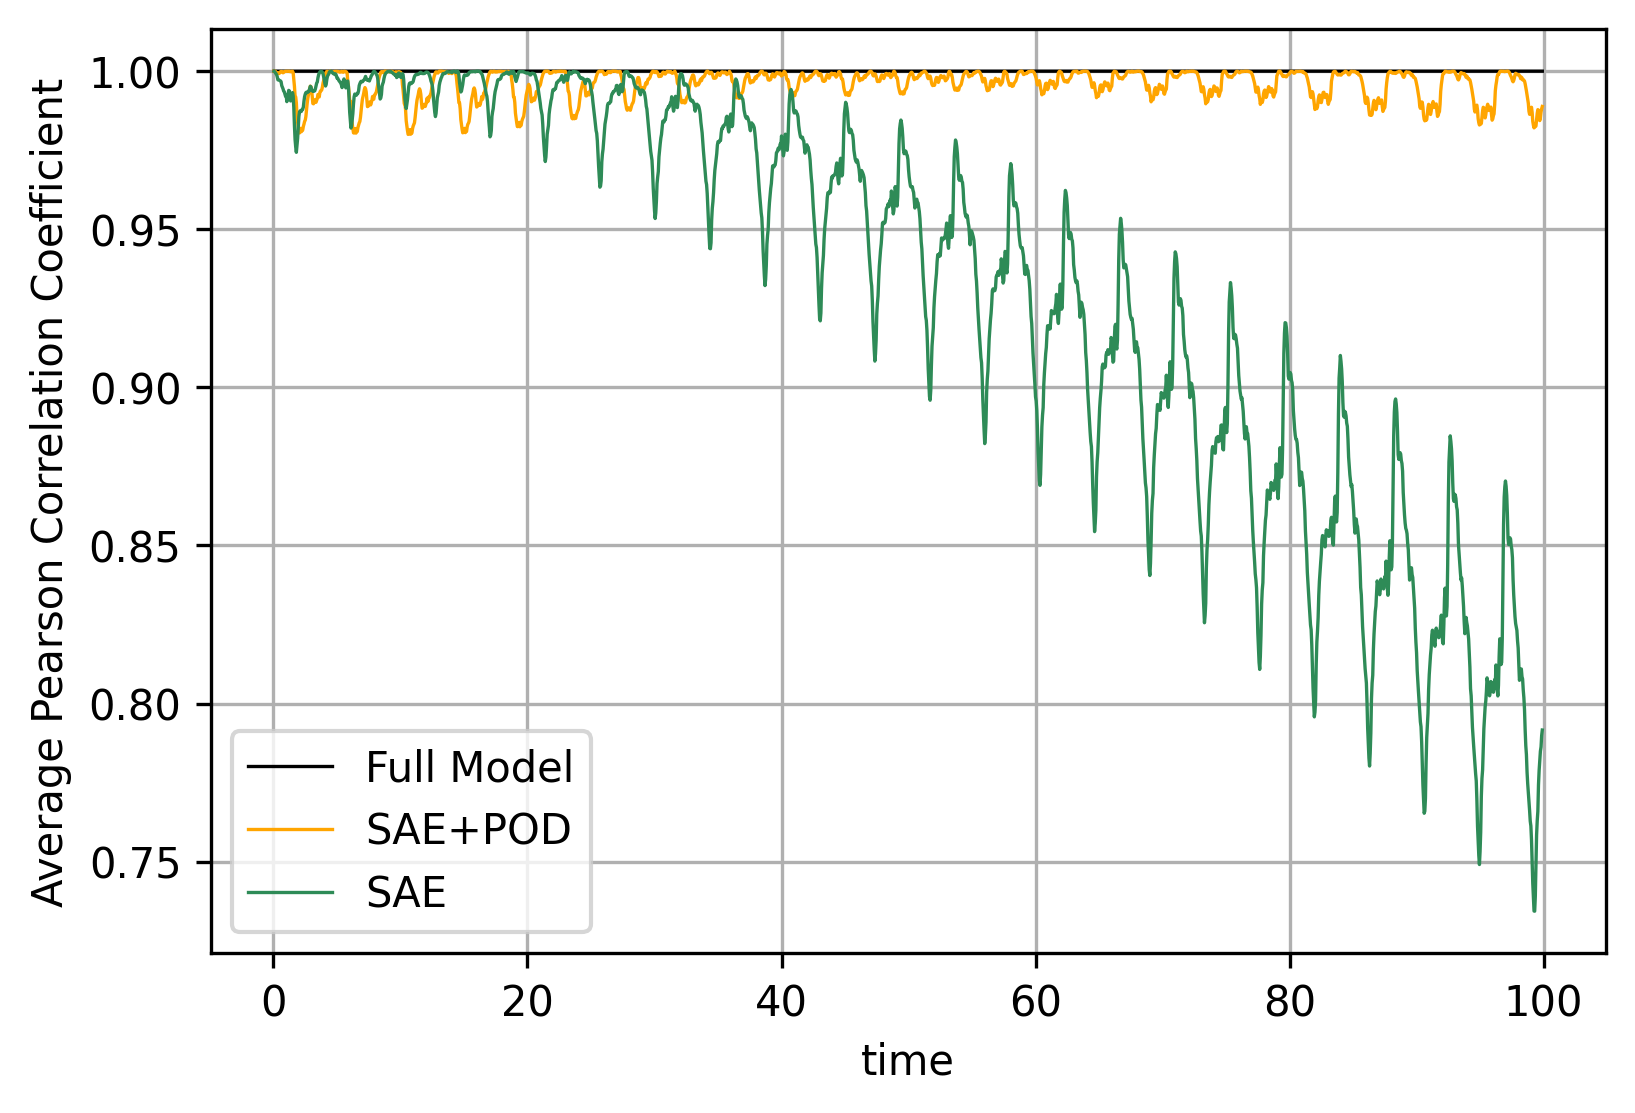

In [ ]:
fig=plt.figure(dpi=300,figsize=(6,4))
plt.plot(taxint[:],np.repeat(1,1998),lw=0.8,label='Full Model',color='k')
plt.plot(taxint[:],pcc_sae_pod[:],lw=0.8,label='SAE+POD',color='orange')
plt.plot(taxint[:],pcc_sae[:],lw=0.8,label='SAE',color='seagreen')
# plt.plot(taxint[:],velocity_test[2:,pt1],color='k',lw=1,label='Full Model')
# plt.plot(taxint,deco_sae[:,pt1],'--',lw=1,label='SAE+POD')
# plt.plot(taxint[:],deco_sae_pod[2:,pt1],'--', lw=1,label='SAE') #,color='royalblue')      #'#ff7f0e')
plt.legend(loc='lower left')
# plt.yticks(ticks=[0.800,0.850,0.900,0.950,1.000],\
#                labels=['0.800','0.850','0.900','0.950','1.000'])
# plt.xlim([2,4.5])
# plt.ylim([0.8,1.02])
plt.xlabel('time')
plt.ylabel('Average Pearson Correlation Coefficient')
plt.grid()

In [ ]:
value = cp(X[1:1999])
print(deco_sae.shape)
print(deco_sae_pod.shape)

value = value.reshape((len(value),128*64))
deco1 = deco_sae.reshape((1998,128*64))
deco2 = deco_sae_pod.reshape((1998,128*64))

(1998, 128, 64)
(1998, 128, 64)


In [ ]:
rmse_sae = np.zeros((len(deco),))
rmse_sae_pod = np.zeros((len(deco),))
for i in range(len(deco)):
  rmse_sae[i] = np.sqrt(((deco1[i,:]-value[i,:]) ** 2).mean())
  rmse_sae_pod[i] = np.sqrt(((deco2[i,:]-value[i,:]) ** 2).mean())

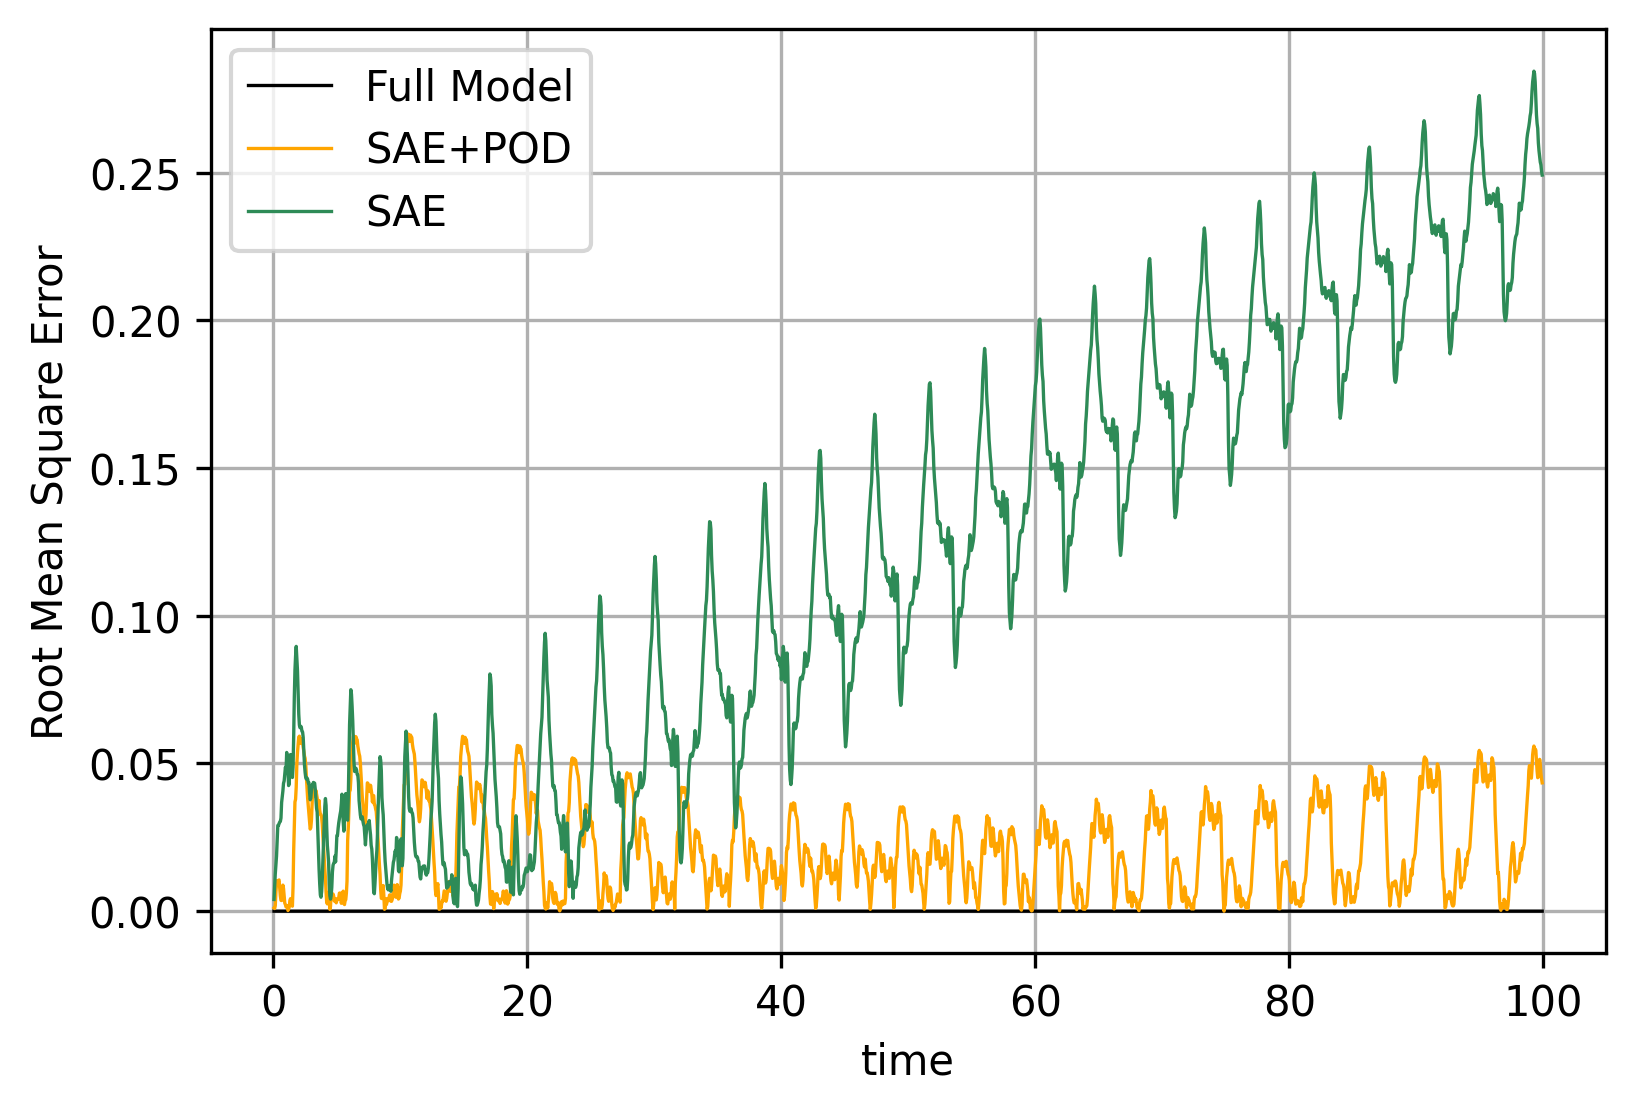

In [ ]:
fig=plt.figure(dpi=300,figsize=(6,4))
pt1 = 460
plt.plot(taxint[:],np.repeat(0,1998),lw=0.8,label='Full Model',color='k')
plt.plot(taxint[:],rmse_sae_pod[:],lw=0.8,label='SAE+POD',color='orange')
plt.plot(taxint[:],rmse_sae[:],lw=0.8,label='SAE',color='seagreen')
# plt.plot(taxint[:],velocity_test[2:,pt1],color='k',lw=1,label='Full Model')
# plt.plot(taxint,deco_sae[:,pt1],'--',lw=1,label='SAE+POD')
# plt.plot(taxint[:],deco_sae_pod[2:,pt1],'--', lw=1,label='SAE') #,color='royalblue')      #'#ff7f0e')
plt.legend(loc='upper left')
# plt.xlim([2,4.5])
# plt.ylim([0.8,1.02])
plt.xlabel('time')
plt.ylabel('Root Mean Square Error')
plt.grid()